# Imports

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow.keras.backend as K
from keras.layers import Activation
from keras.layers import Dense , LSTM, Dropout
from keras.models import Sequential, load_model
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

2024-06-29 09:42:58.107318: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-29 09:42:58.107433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-29 09:42:58.272404: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio) (P50/P2)",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio) ",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)"
]
col_names = index_names + setting_names + sensor_names

In [3]:
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/CMaps/RUL_FD002.txt
/kaggle/input/CMaps/test_FD003.txt
/kaggle/input/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/CMaps/readme.txt
/kaggle/input/CMaps/train_FD003.txt
/kaggle/input/CMaps/test_FD004.txt
/kaggle/input/CMaps/train_FD004.txt
/kaggle/input/CMaps/x.txt
/kaggle/input/CMaps/test_FD002.txt
/kaggle/input/CMaps/train_FD001.txt
/kaggle/input/CMaps/train_FD002.txt
/kaggle/input/CMaps/RUL_FD001.txt
/kaggle/input/CMaps/RUL_FD004.txt
/kaggle/input/CMaps/RUL_FD003.txt
/kaggle/input/CMaps/test_FD001.txt
/kaggle/input/cmaps/CMaps/RUL_FD002.txt
/kaggle/input/cmaps/CMaps/test_FD003.txt
/kaggle/input/cmaps/CMaps/Damage Propagation Modeling.pdf
/kaggle/input/cmaps/CMaps/readme.txt
/kaggle/input/cmaps/CMaps/train_FD003.txt
/kaggle/input/cmaps/CMaps/test_FD004.txt
/kaggle/input/cmaps/CMaps/train_FD004.txt
/kaggle/input/cmaps/CMaps/x.txt
/kaggle/input/cmaps/CMaps/test_FD002.txt
/kaggle/input/cmaps/CMaps/train_FD001.txt
/kaggle/input/cmaps/CMaps/train_FD002.txt
/kaggle/input

In [4]:
df_train = pd.read_csv(('/kaggle/input/cmaps/CMaps/train_FD002.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/kaggle/input/cmaps/CMaps/test_FD002.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/kaggle/input/cmaps/CMaps/RUL_FD002.txt'), sep='\s+', header=None, names=['RUL'])

# Data Pre-Processing

## Add RUL column to train data

In [5]:
def add_RUL(data):
    max_cycles = data.groupby('engine')['cycle'].max().reset_index()
    max_cycles.columns = ['engine', 'max_cycle']
    new_df = data.merge(max_cycles, on='engine')
    new_df["RUL"] = new_df["max_cycle"] - new_df['cycle']
    new_df = new_df.drop("max_cycle", axis=1)
    return new_df

train = add_RUL(df_train)
print(train[index_names+['RUL']].head())

# Display the new DataFrame with the added RUL column
print(train.columns)

   engine  cycle  RUL
0       1      1  148
1       1      2  147
2       1      3  146
3       1      4  145
4       1      5  144
Index(['engine', 'cycle', 'setting_1', 'setting_2', 'setting_3',
       '(Fan inlet temperature) (◦R)', '(LPC outlet temperature) (◦R)',
       '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)',
       '(Fan inlet Pressure) (psia)', '(bypass-duct pressure) (psia)',
       '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)',
       '(Physical core speed) (rpm)', '(Engine pressure ratio) (P50/P2)',
       '(HPC outlet Static pressure) (psia)',
       '(Ratio of fuel flow to Ps30) (pps/psia)',
       '(Corrected fan speed) (rpm)', '(Corrected core speed) (rpm)',
       '(Bypass Ratio) ', '(Burner fuel-air ratio)', '(Bleed Enthalpy)',
       '(Required fan speed)', '(Required fan conversion speed)',
       '(High-pressure turbines Cool air flow)',
       '(Low-pressure turbines Cool air flow)', 'RUL'],
      dtype='object')


In [6]:
X_train = train[setting_names + sensor_names].copy()
X_train = pd.concat([train['engine'], X_train], axis =1)

y_train = train['RUL'].copy()
y_train_clipped = y_train.clip(upper=150)
y_train_clipped = pd.concat([y_train_clipped, train['engine']], axis=1)

X_test = df_test.drop('cycle', axis=1).copy()
# X_test = pd.concat([df_test['engine'], X_test], axis =1)

y_test = df_test_RUL
temp_df = df_test_RUL.reset_index().rename(columns={"index": "engine"})
temp_df["engine"] = temp_df["engine"] + 1

In [7]:
temp2_df = X_test.merge(temp_df, on='engine')

temp2_df['row_number'] = temp2_df.groupby('engine').cumcount(ascending=False)

temp2_df['RUL'] = temp2_df['RUL'] + temp2_df["row_number"]

y_test = temp2_df.drop(["row_number"], axis=1)

y_test = y_test[["engine", "RUL"]]

y_test

,engine,RUL
0,1,275
1,1,274
2,1,273
3,1,272
4,1,271
...,...,...
33986,259,55
33987,259,54
33988,259,53
33989,259,52


## Train test split

In [8]:
def train_val_group_split(X, y, groups, test_size=0.20, random_state=42, print_groups=False):
    # Create a GroupShuffleSplit instance within the function for encapsulation
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # Generate indices for the split
    idx_train, idx_val = next(gss.split(X, y, groups))

    # Option to print group information
    if print_groups:
        train_engines = groups.iloc[idx_train].unique()
        val_engines = groups.iloc[idx_val].unique()
        print(f'Train Split Engines: {train_engines}\nValidate Split Engines: {val_engines}\n')

    # Create the splits
    X_train_split = X.iloc[idx_train].copy()
    y_train_split = y.iloc[idx_train].copy()
    X_val_split = X.iloc[idx_val].copy()
    y_val_split = y.iloc[idx_val].copy()

    return X_train_split, y_train_split, X_val_split, y_val_split

## Use minmax scaler

In [9]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train[sensor_names])
X_train_scaled = X_train.copy()
X_train_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_train[sensor_names]), columns=sensor_names)

X_test_scaled = X_test.copy()
X_test_scaled[sensor_names] = pd.DataFrame(scaler.transform(X_test[sensor_names]), columns=sensor_names, index=X_test.index)

X_train_split_scaled, y_train_clipped_split_scaled, X_val_split_scaled, y_val_clipped_split_scaled = train_val_group_split(
    X_train_scaled, y_train_clipped, train['engine'], print_groups=True)

Train Split Engines: [  1   2   3   4   5   6   8   9  12  13  14  15  17  18  21  22  23  24
  27  28  29  30  32  33  35  36  37  38  39  40  41  42  43  44  45  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66
  67  68  70  71  72  73  74  75  77  79  80  81  82  83  84  85  86  87
  88  89  90  92  94  95  96  99 100 101 103 104 106 107 108 109 110 111
 112 113 116 117 118 119 121 122 123 124 125 126 127 128 129 130 131 132
 133 134 135 136 137 138 139 141 142 144 146 147 148 149 150 152 153 154
 156 157 158 160 161 162 163 164 165 166 167 169 170 171 172 173 175 176
 177 179 181 183 184 185 187 188 189 190 192 193 194 195 196 198 199 200
 201 203 204 208 209 210 211 215 216 217 218 219 220 222 223 225 226 227
 228 230 231 232 233 234 235 236 239 240 241 242 244 245 246 247 248 249
 250 251 252 253 254 255 256 257 258 260]
Validate Split Engines: [  7  10  11  16  19  20  25  26  31  34  46  47  69  76  78  91  93  97
  98 102 105 114 115 120 140 143 145 

## Helper Functions for Pre-Processing

### Generate sequence

No Padding

In [10]:
# aim: to put all the rows belonging to 1 engine in a single matrix.
# Need to iterate over two lists in parallel.
    # e.g., id1 has 149 rows and sequence_length = 50
    # need to zip iterate over two following list of numbers (0,149-50=99),(50,149)
    # row 0 to row 50
    # row 1 to row 51
    # row 2 to row 52
    # ...
    # row 99 to row 149

def gen_sequence(id_df, seq_cols, seq_length = 20): #id_df = e.g., dataframe['engine']==1
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """

    data_matrix = id_df[seq_cols].values #99 , 149
    num_elements = data_matrix.shape[0] #get number of rows of engine id_df (e.g., for engine 1, num_elements = 149)

    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        # will iterate from (0, 149-50+1 = 100), (50, 150)
#         print(start, "--", stop)
        yield data_matrix[start:stop, :]

With Padding

In [11]:
import numpy as np

def gen_sequence_pad(id_df, seq_cols, seq_length=50): 
    """
    Generates sequences of a given length from the dataframe of a single engine.
    Pads sequences with fewer rows than the specified length.
    """
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    if num_elements < seq_length:
        # Pad the sequence with zeros if there are fewer rows than the sequence length
        padded_matrix = np.zeros((seq_length, data_matrix.shape[1]))
        padded_matrix[-num_elements:, :] = data_matrix
        yield padded_matrix
    else:
        for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
            yield data_matrix[start:stop, :]

### Generate label

No padding

In [12]:
def gen_labels(label_df, seq_length = 20):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """

    data_matrix = label_df[['RUL']].values # [[]] so it's DF. [] = series
    
    num_elements = data_matrix.shape[0]
    
    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        # will iterate from (0, 149-50+1 = 100), (50, 150)
#         yield data_matrix[start:stop, :]
        yield data_matrix[stop-1, :]
# generate labels
label_gen = (list(gen_labels(y_train_clipped_split_scaled[y_train_clipped_split_scaled['engine']==id])) 
             for id in y_train_clipped_split_scaled['engine'].unique())

label_array = np.concatenate(list(label_gen)).astype(np.float32)
print("\nlabel_array:\n" , label_array.shape)


label_array:
 (39512, 1)


With padding

In [13]:
import numpy as np

def gen_labels_pad(label_df, seq_length=50):
    """
    Generates labels for sequences of a given length from the dataframe of a single engine.
    Pads labels with zeros if there are fewer rows than the specified length.
    """
    data_matrix = label_df[['RUL']].values # [[]] so it's DF. [] = series
    
    num_elements = data_matrix.shape[0]
    
    if num_elements < seq_length:
        # Pad the labels with zeros if there are fewer rows than the sequence length
        padded_matrix = np.zeros((seq_length, 1))
        padded_matrix[-num_elements:, :] = data_matrix
        yield padded_matrix[-1, :]  # Yield the last label (most recent RUL)
    else:
        for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
            yield data_matrix[stop-1, :]

label_gen = (list(gen_labels(y_train_clipped_split_scaled[y_train_clipped_split_scaled['engine'] == id])) 
             for id in y_train_clipped_split_scaled['engine'].unique())

label_array = np.concatenate(list(label_gen)).astype(np.float32)
print("\nlabel_array:\n", label_array.shape)



label_array:
 (39512, 1)


### LSTM Pre-processing

In [14]:
def lstm_data_preprocessing(X_train_split_scaled, y_train_clipped_split_scaled, sequence_length = 20, padding = False):
    #####
    ##### GENERATE SEQUENCES #####
    #####
    sequence_cols = list(X_train_split_scaled.columns[1:])

    # # TODO for debug 
    # # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
    # val=list(gen_sequence(X_train_split_scaled[X_train_split_scaled['engine']==1], sequence_cols))
    # print(len(val))
    # print(val[0].shape)

    # use generator for the sequences
    # transform each id of the train dataset in a sequence
    if padding == False:
        seq_gen = (list(gen_sequence(X_train_split_scaled[X_train_split_scaled['engine']==id], sequence_cols)) 
                   for id in X_train_split_scaled['engine'].unique())
    else:
        seq_gen = (list(gen_sequence_pad(X_train_split_scaled[X_train_split_scaled['engine']==id], sequence_cols)) 
           for id in X_train_split_scaled['engine'].unique())
    # generate sequences and convert to numpy array
    seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
    print("seq_array:\n" , seq_array.shape)
    
    #####
    ##### GENERATE LABELS #####
    #####
    
#     # TODO for debug 
#     # val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 25 columns)
#     val=list(gen_labels(y_train_clipped_split_scaled[y_train_clipped_split_scaled['engine']==1]))
#     print(len(val))
#     print(val[0])
    
    # generate labels
    if padding == False:
        label_gen = (list(gen_labels(y_train_clipped_split_scaled[y_train_clipped_split_scaled['engine']==id])) 
                     for id in y_train_clipped_split_scaled['engine'].unique())
    else:
        label_gen = (list(gen_labels_pad(y_train_clipped_split_scaled[y_train_clipped_split_scaled['engine']==id])) 
             for id in y_train_clipped_split_scaled['engine'].unique())
    label_array = np.concatenate(list(label_gen)).astype(np.float32)
    print("\nlabel_array:\n" , label_array.shape)
#     print(label_array)
    return seq_array, label_array, X_train_split_scaled, sequence_length, sequence_cols

## Get number of sequences generated for each engine

No padding

In [15]:
def get_sequence_generated(id_df, seq_cols, seq_length = 20): #id_df = e.g., dataframe['engine']==1
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """

    data_matrix = id_df[seq_cols].values #99 , 149
    num_elements = data_matrix.shape[0] #get number of rows of engine id_df (e.g., for engine 1, num_elements = 149)
    counter = 0
    for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
        # will iterate from (0, 149-50+1 = 100), (50, 150)
#         print(start, "--", stop)
        counter += 1
        yield data_matrix[start:stop, :], counter

With padding

In [16]:
import numpy as np

def get_sequence_generated_pad(id_df, seq_cols, seq_length=50): 
    """
    Generates sequences of a given length from the dataframe of a single engine.
    Pads sequences with fewer rows than the specified length.
    """
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    counter = 0
    if num_elements < seq_length:
        # Pad the sequence with zeros if there are fewer rows than the sequence length
        padded_matrix = np.zeros((seq_length, data_matrix.shape[1]))
        padded_matrix[-num_elements:, :] = data_matrix
        counter += 1
        yield padded_matrix, counter
    else:
        for start, stop in zip(range(0, num_elements - seq_length + 1), range(seq_length, num_elements + 1)):
            counter += 1
            yield data_matrix[start:stop, :], counter

In [17]:
# ## Check for engine 1 ##
# seq_gen = get_sequence_generated(X_train_split_scaled[X_train_split_scaled['engine']==1], sequence_cols)
# # Generate sequences and convert to numpy array
# sequences = []
# counter = 0

# for seq, count in seq_gen:
#     sequences.append(seq)
#     counter = count

# counter_seq_array = np.concatenate(sequences).astype(np.float32)

# print("seq_array shape:", counter_seq_array.shape)
# print("Number of sequences generated:", counter)

## Wrapper function - get last index of sequence for each engine

In [18]:
def lstm_get_sequence_indices(X_train_split_scaled, y_train_clipped_split_scaled, sequence_length=20, padding=False):
    # Generate sequences
    sequence_cols = list(X_train_split_scaled.columns[1:])
    
    sequence_counts = []

    if padding == False:
        seq_gen = ((get_sequence_generated(X_train_split_scaled[X_train_split_scaled['engine']==id], sequence_cols, sequence_length)) 
                   for id in X_train_split_scaled['engine'].unique())
    else:
        # Placeholder for padding implementation
        seq_gen = ((get_sequence_generated_pad(X_train_split_scaled[X_train_split_scaled['engine']==id], sequence_cols, sequence_length)) 
                   for id in X_train_split_scaled['engine'].unique())
    
    # Collect sequences into a list
    sequences = []
    for gen in seq_gen:
        count = 0
        for seq, counter in gen:
            count = counter
        sequence_counts.append(count)

    
    return sequence_counts

In [19]:
def cumulative_sum(input_list):
    input_array = np.array(input_list)
    cumulative_sum_array = np.cumsum(input_array)
    cumulative_sum_array= cumulative_sum_array-1
    return cumulative_sum_array.tolist()

Without padding

In [20]:
train_counter = lstm_get_sequence_indices(X_train_split_scaled, y_train_clipped_split_scaled)
print("Number of sequences generated for each engine:", train_counter)
print("Number of engines:", len(train_counter))

Number of sequences generated for each engine: [130, 250, 187, 216, 135, 156, 132, 180, 230, 208, 174, 190, 161, 190, 170, 173, 192, 172, 157, 181, 132, 147, 262, 176, 177, 184, 191, 158, 195, 174, 243, 202, 192, 186, 132, 220, 149, 203, 274, 155, 129, 180, 140, 144, 121, 143, 175, 158, 199, 165, 149, 263, 187, 151, 126, 166, 137, 175, 177, 220, 139, 212, 166, 162, 202, 269, 181, 151, 240, 328, 171, 151, 346, 169, 169, 169, 287, 179, 189, 183, 193, 192, 261, 209, 253, 126, 137, 201, 202, 181, 359, 213, 188, 158, 325, 155, 191, 166, 207, 248, 149, 180, 237, 284, 183, 163, 261, 164, 140, 228, 275, 141, 129, 181, 175, 144, 189, 205, 244, 188, 260, 270, 203, 165, 273, 174, 280, 218, 289, 193, 205, 175, 184, 230, 146, 185, 213, 166, 160, 239, 155, 132, 183, 145, 162, 162, 236, 188, 152, 143, 149, 129, 190, 238, 114, 153, 129, 171, 220, 186, 200, 208, 172, 250, 218, 131, 182, 165, 195, 207, 210, 143, 218, 137, 215, 176, 199, 137, 159, 165, 243, 167, 125, 223, 171, 140, 164, 220, 244, 247, 16

In [21]:
output_train_counter = cumulative_sum(train_counter)
output_train_counter[:5]

[129, 379, 566, 782, 917]

In [22]:
test_counter = lstm_get_sequence_indices(X_test_scaled, y_test)
print("Number of sequences generated for each engine:", test_counter)
print("Number of engines:", len(test_counter))

Number of sequences generated for each engine: [239, 36, 146, 67, 129, 44, 165, 154, 142, 65, 143, 55, 145, 141, 146, 69, 245, 21, 153, 82, 109, 140, 30, 191, 128, 57, 49, 4, 82, 165, 104, 151, 116, 33, 58, 144, 30, 108, 130, 164, 191, 118, 165, 145, 176, 113, 62, 113, 46, 145, 18, 146, 130, 55, 104, 54, 57, 228, 3, 125, 51, 186, 155, 214, 348, 44, 127, 199, 139, 245, 46, 124, 132, 84, 173, 203, 48, 109, 94, 259, 57, 77, 2, 185, 164, 64, 112, 147, 40, 144, 259, 104, 57, 98, 59, 121, 194, 94, 144, 130, 19, 103, 167, 122, 42, 53, 113, 155, 125, 200, 112, 90, 26, 134, 191, 152, 36, 78, 183, 141, 40, 10, 42, 130, 60, 80, 107, 91, 199, 122, 54, 103, 167, 167, 101, 58, 207, 181, 97, 287, 50, 144, 207, 124, 123, 125, 59, 138, 51, 177, 122, 71, 127, 39, 53, 56, 142, 152, 168, 105, 155, 166, 125, 180, 16, 78, 59, 88, 61, 66, 224, 109, 98, 32, 64, 181, 172, 35, 137, 135, 180, 115, 131, 45, 235, 147, 65, 67, 159, 139, 76, 142, 226, 31, 243, 90, 40, 101, 98, 41, 6, 105, 96, 22, 12, 143, 122, 147, 

In [23]:
output_test_counter = cumulative_sum(test_counter)
output_test_counter[:5]

[238, 274, 420, 487, 616]

With Padding

In [24]:
train_counter_pad = lstm_get_sequence_indices(X_train_split_scaled, y_train_clipped_split_scaled, sequence_length=50, padding=True)
print("Number of sequences generated for each engine:", train_counter_pad)
print("Number of engines:", len(train_counter_pad))

Number of sequences generated for each engine: [100, 220, 157, 186, 105, 126, 102, 150, 200, 178, 144, 160, 131, 160, 140, 143, 162, 142, 127, 151, 102, 117, 232, 146, 147, 154, 161, 128, 165, 144, 213, 172, 162, 156, 102, 190, 119, 173, 244, 125, 99, 150, 110, 114, 91, 113, 145, 128, 169, 135, 119, 233, 157, 121, 96, 136, 107, 145, 147, 190, 109, 182, 136, 132, 172, 239, 151, 121, 210, 298, 141, 121, 316, 139, 139, 139, 257, 149, 159, 153, 163, 162, 231, 179, 223, 96, 107, 171, 172, 151, 329, 183, 158, 128, 295, 125, 161, 136, 177, 218, 119, 150, 207, 254, 153, 133, 231, 134, 110, 198, 245, 111, 99, 151, 145, 114, 159, 175, 214, 158, 230, 240, 173, 135, 243, 144, 250, 188, 259, 163, 175, 145, 154, 200, 116, 155, 183, 136, 130, 209, 125, 102, 153, 115, 132, 132, 206, 158, 122, 113, 119, 99, 160, 208, 84, 123, 99, 141, 190, 156, 170, 178, 142, 220, 188, 101, 152, 135, 165, 177, 180, 113, 188, 107, 185, 146, 169, 107, 129, 135, 213, 137, 95, 193, 141, 110, 134, 190, 214, 217, 134, 224, 7

In [25]:
output_train_counter_pad = cumulative_sum(train_counter_pad)
output_train_counter_pad[:5]

[99, 319, 476, 662, 767]

In [26]:
test_counter_pad = lstm_get_sequence_indices(X_test_scaled, y_test, sequence_length=50, padding=True)
print("Number of sequences generated for each engine:", test_counter_pad)
print("Number of engines:", len(test_counter_pad))

Number of sequences generated for each engine: [209, 6, 116, 37, 99, 14, 135, 124, 112, 35, 113, 25, 115, 111, 116, 39, 215, 1, 123, 52, 79, 110, 1, 161, 98, 27, 19, 1, 52, 135, 74, 121, 86, 3, 28, 114, 1, 78, 100, 134, 161, 88, 135, 115, 146, 83, 32, 83, 16, 115, 1, 116, 100, 25, 74, 24, 27, 198, 1, 95, 21, 156, 125, 184, 318, 14, 97, 169, 109, 215, 16, 94, 102, 54, 143, 173, 18, 79, 64, 229, 27, 47, 1, 155, 134, 34, 82, 117, 10, 114, 229, 74, 27, 68, 29, 91, 164, 64, 114, 100, 1, 73, 137, 92, 12, 23, 83, 125, 95, 170, 82, 60, 1, 104, 161, 122, 6, 48, 153, 111, 10, 1, 12, 100, 30, 50, 77, 61, 169, 92, 24, 73, 137, 137, 71, 28, 177, 151, 67, 257, 20, 114, 177, 94, 93, 95, 29, 108, 21, 147, 92, 41, 97, 9, 23, 26, 112, 122, 138, 75, 125, 136, 95, 150, 1, 48, 29, 58, 31, 36, 194, 79, 68, 2, 34, 151, 142, 5, 107, 105, 150, 85, 101, 15, 205, 117, 35, 37, 129, 109, 46, 112, 196, 1, 213, 60, 10, 71, 68, 11, 1, 75, 66, 1, 1, 113, 92, 117, 82, 133, 106, 138, 110, 26, 22, 51, 1, 1, 112, 5, 6, 13

In [27]:
output_test_counter_pad = cumulative_sum(test_counter_pad)
output_test_counter_pad[:5]

[208, 214, 330, 367, 466]

## Helper Functions for Evaluation

In [28]:
def lstm_test_evaluation_graphs(model, history, seq_array, label_array, indices):
    # Filter the seq_array and label_array based on the given indices
    seq_array_filtered = seq_array[indices]
    label_array_filtered = label_array[indices]

    # summarize history for R^2
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['r2_keras'])
    plt.plot(history.history['val_r2_keras'])
    plt.title('model r^2')
    plt.ylabel('R^2')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_r2.png")

    # summarize history for MAE
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('model MAE')
    plt.ylabel('MAE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_mae.png")

    # summarize history for Loss
    fig_acc = plt.figure(figsize=(10, 10))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # fig_acc.savefig("model_regression_loss.png")

    # training metrics
    scores = model.evaluate(seq_array_filtered, label_array_filtered, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array_filtered, verbose=1, batch_size=200)
    y_true = label_array_filtered
    
    scoring_function = calculate_scoring_function(y_true, y_pred)
    print('\nScoring Function: {}'.format(scoring_function))
    
    average_scoring_function = scoring_function / len(y_true)
    print('\nAverage Scoring Function: {}'.format(average_scoring_function))

    test_set = pd.DataFrame(y_pred)
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)
    
    y_hat_test = y_pred
    RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate(y_true, y_hat_test, label='test')
    
    return RMSE_Test, R2_Test, Score_Test, average_score_test

def calculate_scoring_function(y_true, y_hat):
    # Calculate custom score
    score = 0
    for j in range(len(y_true)):
        d = y_hat[j] - y_true[j]
        if d >= 0:
            score += 1 -math.exp(-d / 10)
        else:
            score += 1- math.exp(d / 13)
    return score

def evaluate(y_true, y_hat, label='test'):
    # Convert y_true to numpy array if it is a pandas DataFrame or Series
    if isinstance(y_true, (pd.DataFrame, pd.Series)):
        y_true = y_true.values

    # Convert y_hat to numpy array if it is a pandas DataFrame or Series
    if isinstance(y_hat, (pd.DataFrame, pd.Series)):
        y_hat = y_hat.values
        
    y_true = np.ravel(y_true)
    y_hat = np.ravel(y_hat)

    # Calculate MSE and derive RMSE
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    
    # Calculate R-squared
    variance = r2_score(y_true, y_hat)
    
    # Calculate custom score
    score = 0
    for j in range(len(y_true)):
        d = y_hat[j] - y_true[j]
        if d >= 0:
            score += 1 - math.exp(-d / 10)
        else:
            score += 1 - math.exp(d / 13)
    
    average_score = score / len(y_true)
    # Print all metrics
    print('{} set RMSE: {:.2f}, R2: {:.2f}, Scoring Function: {:.2f}, Average Scoring Function: {:.2f}'.format(label, rmse, variance, score, average_score))
    
    # Return metrics
    return rmse, variance, score, average_score

def evaluate_test_data(model, seq_array, label_array, indices):
    # Filter the seq_array and label_array based on the given indices
    seq_array_filtered = seq_array[indices]
    label_array_filtered = label_array[indices]

    # training metrics
    scores = model.evaluate(seq_array_filtered, label_array_filtered, verbose=1, batch_size=200)
    print('\nMAE: {}'.format(scores[1]))
    print('\nR^2: {}'.format(scores[2]))

    y_pred = model.predict(seq_array_filtered, verbose=1, batch_size=200)
    y_true = label_array_filtered
    
    scoring_function = calculate_scoring_function(y_true, y_pred)
    print('\nScoring Function: {}'.format(scoring_function))

    test_set = pd.DataFrame(y_pred)
    test_set.head()
    # test_set.to_csv('submit_train.csv', index = None)
    
    y_hat_test = y_pred
    RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate(y_true, y_hat_test, label='test')
    
    return RMSE_Test, R2_Test, Score_Test, average_score_test

# Train using window size of 20

Execute LSTM data pre-processing on train and test data

In [29]:
seq_array, label_array, X_train_split_scaled, sequence_length, sequence_cols = lstm_data_preprocessing(X_train_split_scaled, y_train_clipped_split_scaled)

seq_array:
 (39512, 20, 24)

label_array:
 (39512, 1)


In [30]:
test_seq_array, test_label_array, X_test_split_scaled, test_sequence_length, test_sequence_cols = lstm_data_preprocessing(X_test_scaled, y_test)

seq_array:
 (29070, 20, 24)

label_array:
 (29070, 1)


## 1. Baseline Training

In [31]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

 
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    
    # list all data in history
    print(history.history.keys())
    
    return model, history

In [32]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
188/188 - 5s - 27ms/step - loss: 8241.4883 - mae: 77.3266 - r2_keras: -2.4154e+00 - val_loss: 8325.9189 - val_mae: 77.5624 - val_r2_keras: -4.5202e+01
Epoch 2/60
188/188 - 1s - 5ms/step - loss: 6808.4561 - mae: 69.3437 - r2_keras: -1.8214e+00 - val_loss: 6981.6074 - val_mae: 70.4497 - val_r2_keras: -3.8527e+01
Epoch 3/60
188/188 - 1s - 5ms/step - loss: 5647.2988 - mae: 62.8265 - r2_keras: -1.3394e+00 - val_loss: 5819.5664 - val_mae: 64.2618 - val_r2_keras: -3.2417e+01
Epoch 4/60
188/188 - 1s - 5ms/step - loss: 4668.7837 - mae: 57.2762 - r2_keras: -9.3225e-01 - val_loss: 4839.1436 - val_mae: 58.9915 - val_r2_keras: -2.6873e+01
Epoch 5/60
188/188 - 1s - 5ms/step - loss: 3871.2166 - mae: 52.6744 - r2_keras: -6.0178e-01 - val_loss: 4042.5393 - val_mae: 54.6560 - val_r2_keras: -2.1913e+01
Epoch 6/60
188/188 - 1s - 5ms/step - loss: 3252.9895 - mae: 49.0052 - r2_keras: -3.4516e-01 - val_loss: 3422.8486 - val_mae: 51.2136 - val_r2_keras: -1.7500e+01
Epoch 7/60
188/188 - 1s - 5m

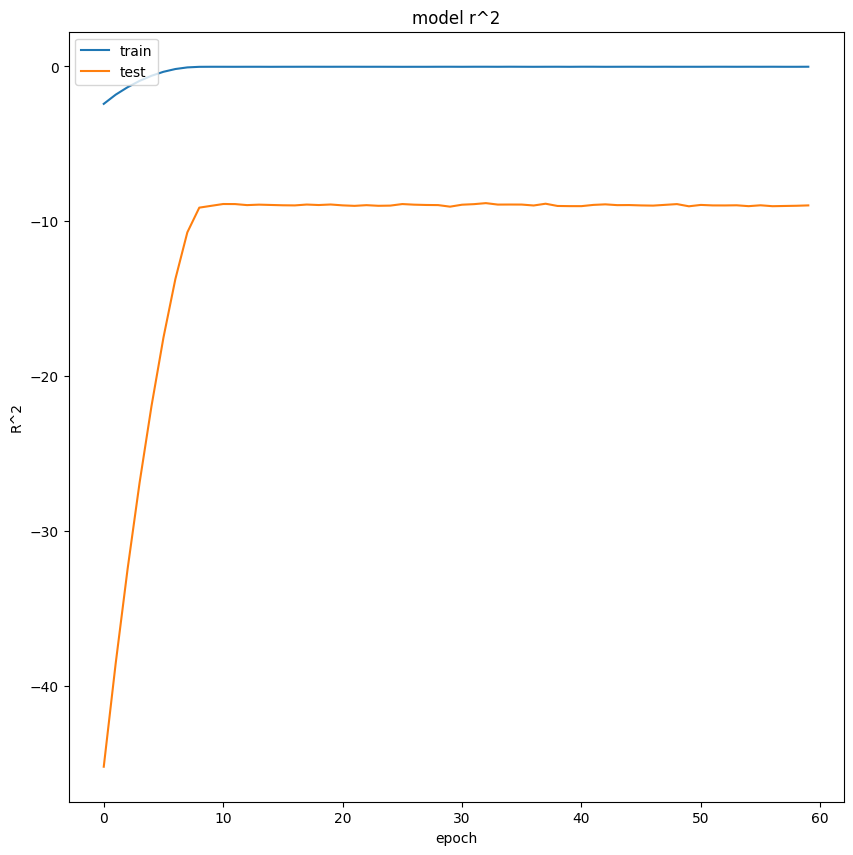

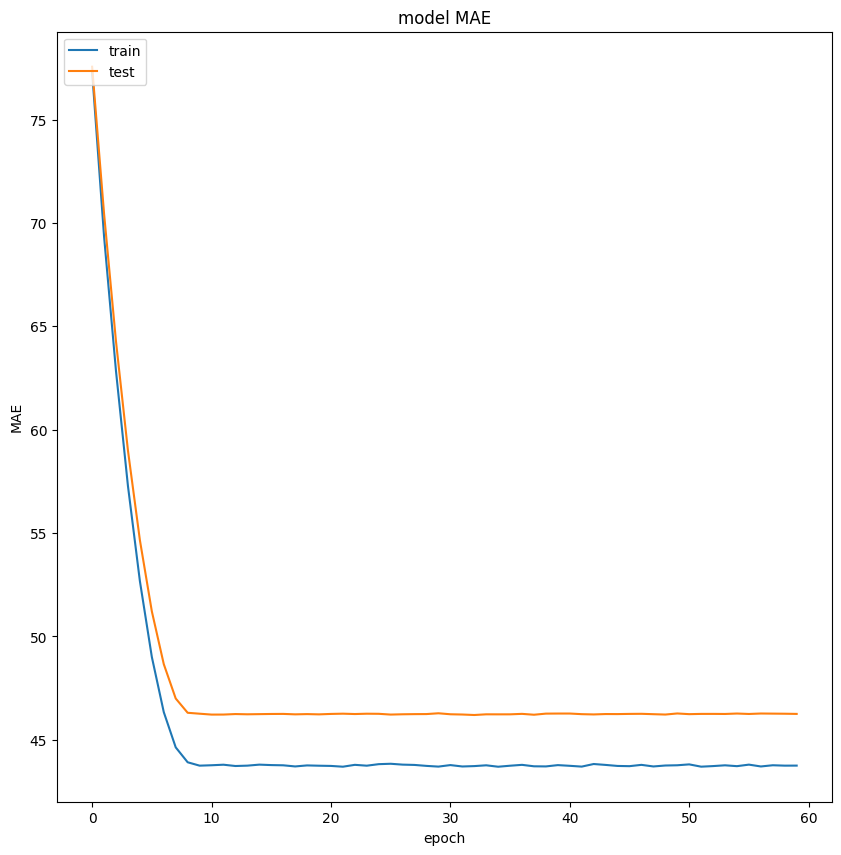

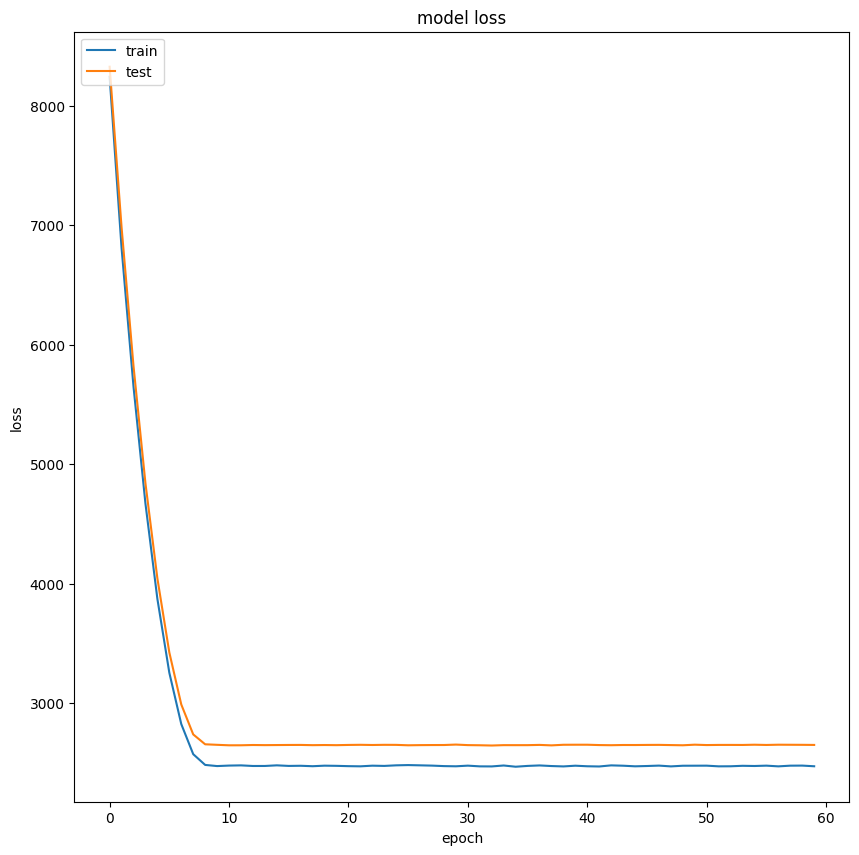

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 8073.2319 - mae: 89.8512 - r2_keras: -10979595255808.0000

MAE: 89.85115814208984

R^2: -8396161417216.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step

Scoring Function: 207.9739458673125

Average Scoring Function: 0.9998747397466947
test set RMSE: 89.85, R2: 0.00, Scoring Function: 207.97, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(89.851166, 0.0, 207.97394585813686, 0.999874739702581)

In [33]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [34]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2959.7141 - mae: 45.9206 - r2_keras: -0.0329 

MAE: 46.01348876953125

R^2: -0.024877607822418213
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 220.82449080244336
test set RMSE: 54.47, R2: -0.03, Scoring Function: 220.82, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(54.47252, -0.025965632333564415, 220.82449088137523, 0.8526042118972016)

In [35]:
Results=pd.DataFrame({'Model':['LSTM-Baseline'],
                          'RMSE-Train':[RMSE_Train],
                          'R2-Train':[R2_Train],
                          'Score-Train':[Score_Train],             
                          'RMSE-Test':[RMSE_Test],
                          'R2-Test':[R2_Test],
                          'Score-Test':[Score_Test]})
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491


## 2. Increase dropout from 0.2 to 0.5

In [36]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
   
    # list all data in history
    print(history.history.keys())
    
    return model, history

In [37]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
188/188 - 3s - 16ms/step - loss: 8458.1895 - mae: 78.5379 - r2_keras: -2.5031e+00 - val_loss: 8549.1719 - val_mae: 78.7390 - val_r2_keras: -4.6281e+01
Epoch 2/60
188/188 - 1s - 5ms/step - loss: 7013.9189 - mae: 70.4891 - r2_keras: -1.9015e+00 - val_loss: 7181.8945 - val_mae: 71.5129 - val_r2_keras: -3.9544e+01
Epoch 3/60
188/188 - 1s - 5ms/step - loss: 5834.0742 - mae: 63.8639 - r2_keras: -1.4150e+00 - val_loss: 5993.7378 - val_mae: 65.1915 - val_r2_keras: -3.3359e+01
Epoch 4/60
188/188 - 1s - 5ms/step - loss: 4846.3076 - mae: 58.2625 - r2_keras: -1.0040e+00 - val_loss: 4988.9312 - val_mae: 59.8016 - val_r2_keras: -2.7752e+01
Epoch 5/60
188/188 - 1s - 5ms/step - loss: 4041.6624 - mae: 53.6407 - r2_keras: -6.6973e-01 - val_loss: 4165.3052 - val_mae: 55.3287 - val_r2_keras: -2.2717e+01
Epoch 6/60
188/188 - 1s - 5ms/step - loss: 3402.5002 - mae: 49.8305 - r2_keras: -4.0848e-01 - val_loss: 3522.1514 - val_mae: 51.7718 - val_r2_keras: -1.8260e+01
Epoch 7/60
188/188 - 1s - 5m

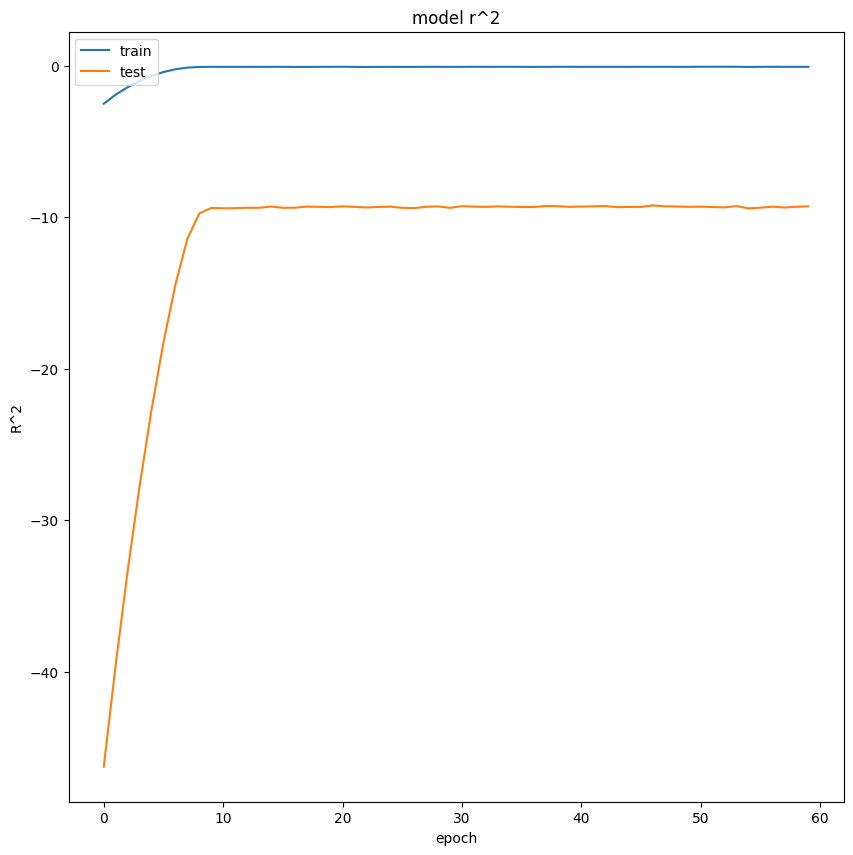

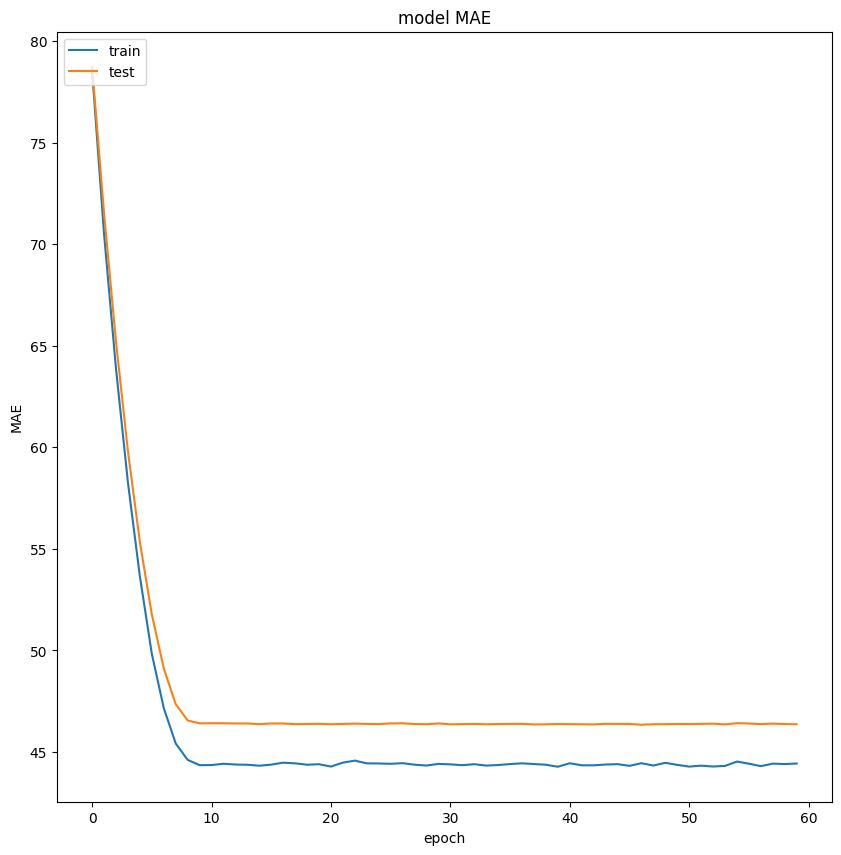

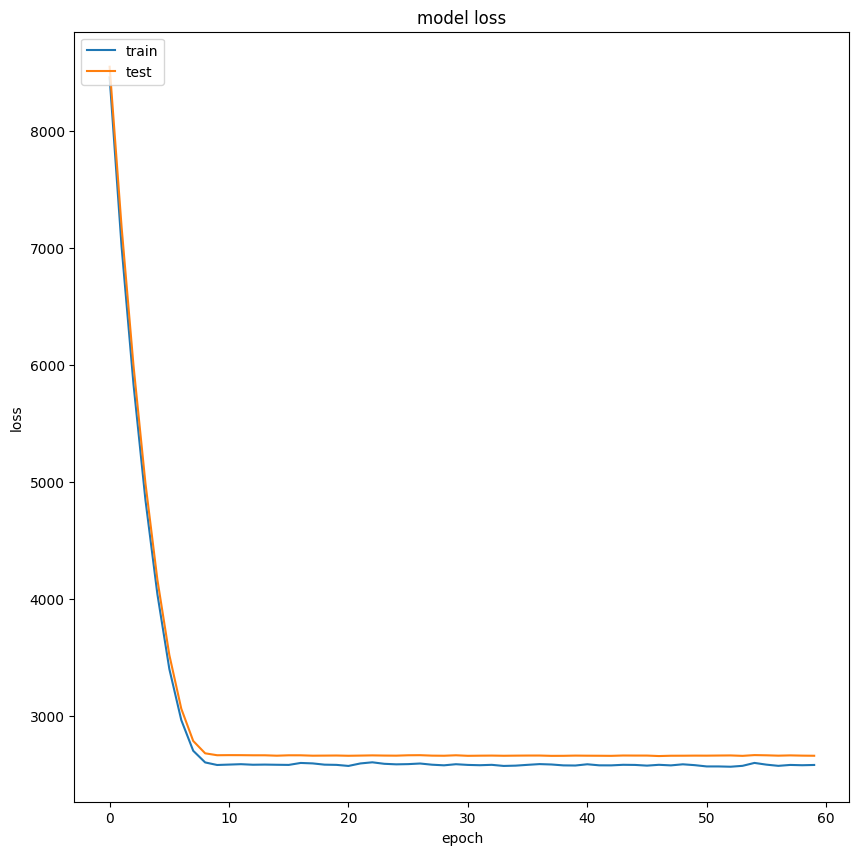

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7890.2598 - mae: 88.8271 - r2_keras: -10730752442368.0000 

MAE: 88.82714080810547

R^2: -8205869514752.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step

Scoring Function: 207.97113643804838

Average Scoring Function: 0.9998612328752325
test set RMSE: 88.83, R2: 0.00, Scoring Function: 207.97, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(88.827126, 0.0, 207.97113643762478, 0.9998612328731961)

In [38]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [39]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2940.9355 - mae: 45.7659 - r2_keras: -0.0279 

MAE: 45.868534088134766

R^2: -0.02152317762374878
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 220.50171261731822
test set RMSE: 54.32, R2: -0.02, Scoring Function: 220.50, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(54.31902, -0.020191554603093742, 220.50171252009528, 0.8513579633980513)

In [40]:
Results=pd.concat([Results,pd.DataFrame({'Model':['increase-dropout-from-0.2-to-0.5'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713


## 3. Add kernel regularizer

In [41]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True,
            kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False,
                kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out, kernel_regularizer=l2(0.01)))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())
    history = model.fit(seq_array, label_array, epochs=60, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [42]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
147/147 - 3s - 19ms/step - loss: 8677.1377 - mae: 79.7307 - r2_keras: -2.5871e+00 - val_loss: 8932.4482 - val_mae: 80.7543 - val_r2_keras: -3.1448e+00
Epoch 2/60
147/147 - 1s - 5ms/step - loss: 7478.3872 - mae: 73.0788 - r2_keras: -2.0905e+00 - val_loss: 7804.1045 - val_mae: 74.8051 - val_r2_keras: -2.6110e+00
Epoch 3/60
147/147 - 1s - 5ms/step - loss: 6483.5010 - mae: 67.5123 - r2_keras: -1.6758e+00 - val_loss: 6791.9502 - val_mae: 69.4426 - val_r2_keras: -2.1342e+00
Epoch 4/60
147/147 - 1s - 5ms/step - loss: 5591.6445 - mae: 62.4976 - r2_keras: -1.3117e+00 - val_loss: 5887.7236 - val_mae: 64.6237 - val_r2_keras: -1.7107e+00
Epoch 5/60
147/147 - 1s - 5ms/step - loss: 4822.5142 - mae: 58.1425 - r2_keras: -9.9041e-01 - val_loss: 5096.7026 - val_mae: 60.3803 - val_r2_keras: -1.3430e+00
Epoch 6/60
147/147 - 1s - 5ms/step - loss: 4160.1416 - mae: 54.3402 - r2_keras: -7.1627e-01 - val_loss: 4416.5620 - val_mae: 56.6974 - val_r2_keras: -1.0300e+00
Epoch 7/60
147/147 - 1s - 9m

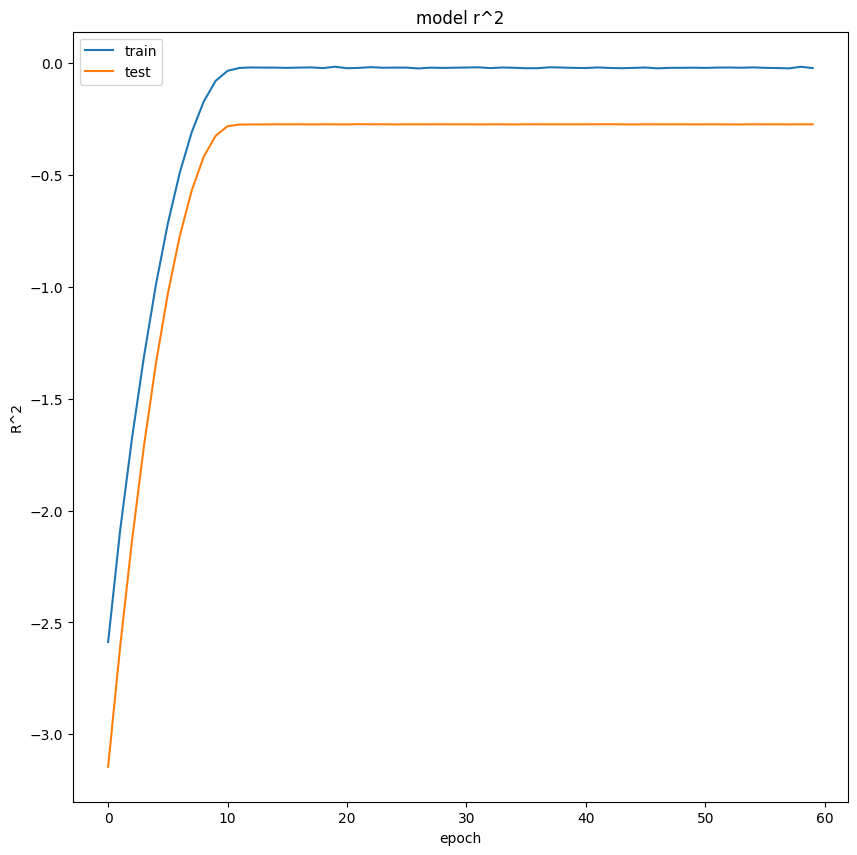

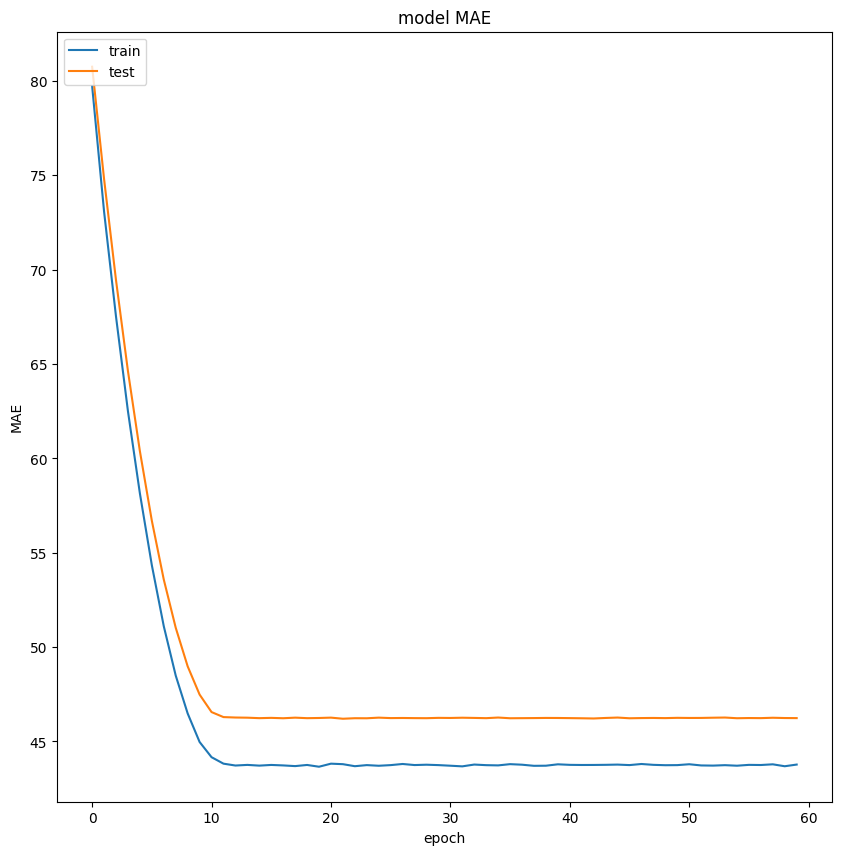

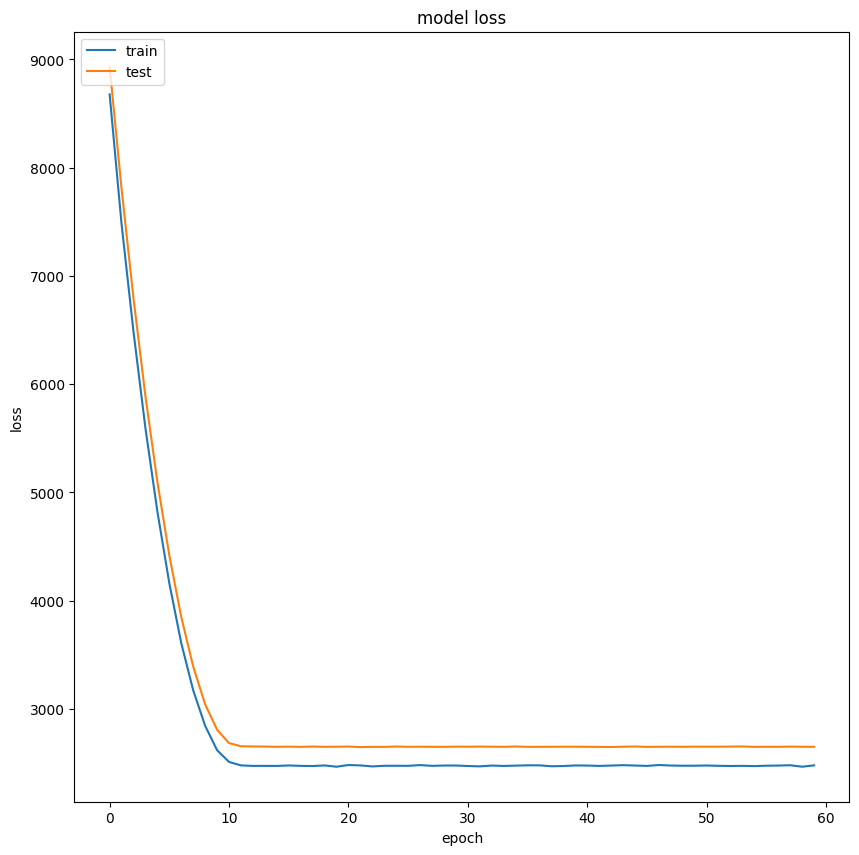

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8094.1416 - mae: 89.9589 - r2_keras: -11005952262144.0000 

MAE: 89.95894622802734

R^2: -8416316096512.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

Scoring Function: 207.97422515731202

Average Scoring Function: 0.999876082487077
test set RMSE: 89.96, R2: 0.00, Scoring Function: 207.97, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(89.95895, 0.0, 207.9742251622288, 0.9998760825107154)

In [43]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [44]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2963.3428 - mae: 45.9369 - r2_keras: -0.0334 

MAE: 46.02888488769531

R^2: -0.02527254819869995
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 220.8433392497171
test set RMSE: 54.49, R2: -0.03, Scoring Function: 220.84, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(54.489773, -0.0266155488583093, 220.8433392027523, 0.852676985338812)

In [45]:
Results=pd.concat([Results,pd.DataFrame({'Model':['add-kernel-regularizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339


## 4. Increase LSTM units, do without regularizer

In [46]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=200,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=100,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())
    history = model.fit(seq_array, label_array, epochs=20, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [47]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 200)        │       180,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,501 (1.15 MB)

 Trainable params: 300,501 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
147/147 - 3s - 20ms/step - loss: 7413.0698 - mae: 72.7306 - r2_keras: -2.0682e+00 - val_loss: 7159.7554 - val_mae: 71.3953 - val_r2_keras: -2.3073e+00
Epoch 2/20
147/147 - 1s - 8ms/step - loss: 5521.5488 - mae: 62.1142 - r2_keras: -1.2797e+00 - val_loss: 5408.6357 - val_mae: 62.0599 - val_r2_keras: -1.4877e+00
Epoch 3/20
147/147 - 1s - 9ms/step - loss: 4131.4717 - mae: 54.1574 - r2_keras: -7.0882e-01 - val_loss: 4094.2053 - val_mae: 54.9393 - val_r2_keras: -8.8344e-01
Epoch 4/20
147/147 - 1s - 8ms/step - loss: 3165.7954 - mae: 48.4767 - r2_keras: -3.0655e-01 - val_loss: 3205.4185 - val_mae: 49.9640 - val_r2_keras: -4.8874e-01
Epoch 5/20
147/147 - 1s - 8ms/step - loss: 2618.6902 - mae: 44.9853 - r2_keras: -7.9497e-02 - val_loss: 2742.8911 - val_mae: 47.0359 - val_r2_keras: -3.0128e-01
Epoch 6/20
147/147 - 1s - 8ms/step - loss: 2460.6704 - mae: 43.7528 - r2_keras: -1.4691e-02 - val_loss: 2650.3225 - val_mae: 46.2608 - val_r2_keras: -2.7322e-01
Epoch 7/20
147/147 - 1s - 8m

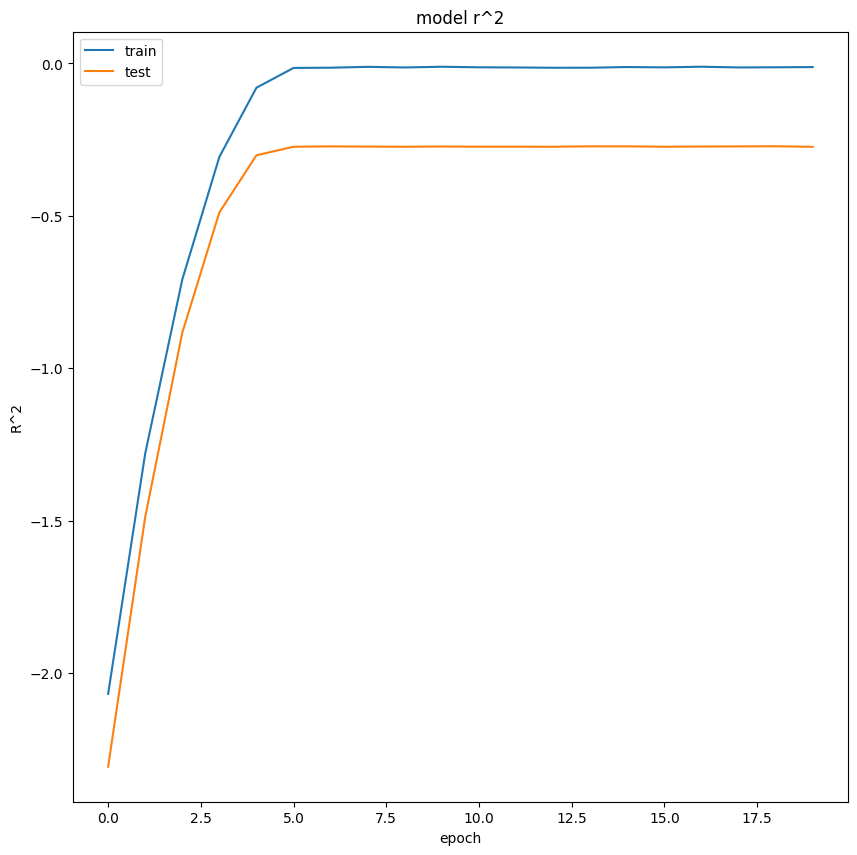

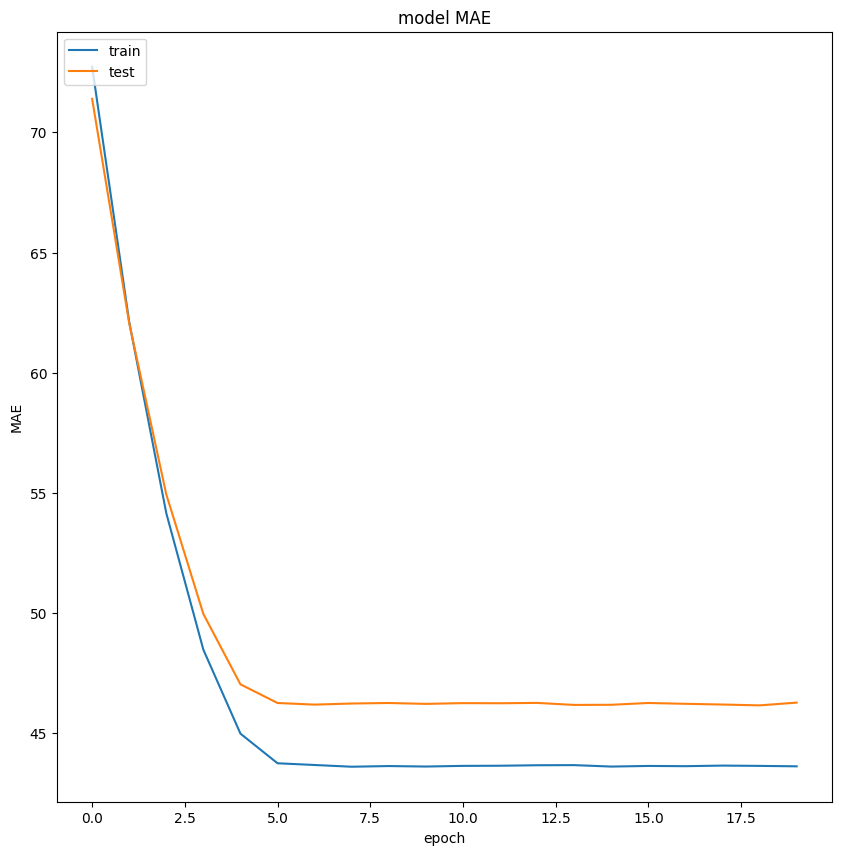

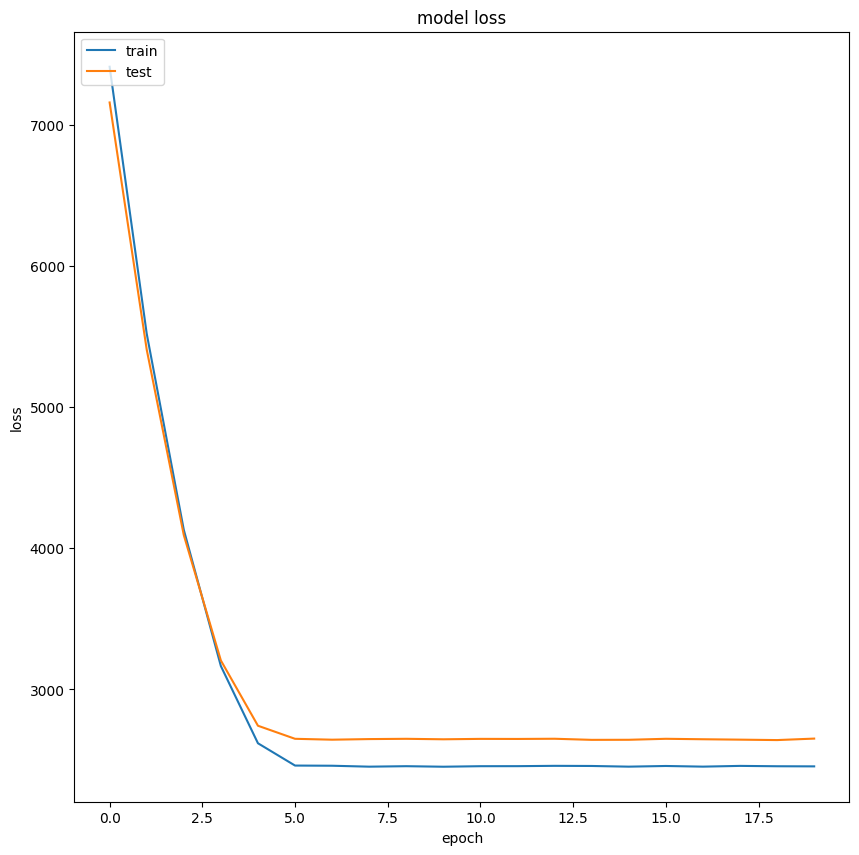

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 8031.9160 - mae: 89.6210 - r2_keras: -10923405213696.0000 

MAE: 89.62095642089844

R^2: -8353192345600.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step

Scoring Function: 207.97333909932192

Average Scoring Function: 0.9998718225928939
test set RMSE: 89.62, R2: 0.00, Scoring Function: 207.97, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(89.62095, 0.0, 207.97333910949155, 0.9998718226417863)

In [48]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [49]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2955.3098 - mae: 45.8856 - r2_keras: -0.0317 

MAE: 45.98060607910156

R^2: -0.02406090497970581
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 220.77261537436547
test set RMSE: 54.44, R2: -0.02, Scoring Function: 220.77, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(54.43637, -0.024604400463301923, 220.7726154490422, 0.8524039206526726)

In [50]:
Results=pd.concat([Results,pd.DataFrame({'Model':['increase-LSTM-units-do-without-regularizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339
3,increase-LSTM-units-do-without-regularizer,89.620949,0.0,207.973339,54.436371,-0.024604,220.772615


## 5. Add 1 more LSTM layer

In [51]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
        units=50,
        return_sequences=True,
        ))
    model.add(Dropout(0.2))
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    history = model.fit(seq_array, label_array, epochs=60, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [52]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 20, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,451 (392.39 KB)

 Trainable params: 100,451 (392.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
147/147 - 3s - 23ms/step - loss: 8577.3486 - mae: 79.1918 - r2_keras: -2.5457e+00 - val_loss: 8804.4932 - val_mae: 80.0852 - val_r2_keras: -3.0845e+00
Epoch 2/60
147/147 - 1s - 7ms/step - loss: 7342.5498 - mae: 72.3348 - r2_keras: -2.0306e+00 - val_loss: 7666.6938 - val_mae: 74.0791 - val_r2_keras: -2.5462e+00
Epoch 3/60
147/147 - 1s - 7ms/step - loss: 6356.0415 - mae: 66.8199 - r2_keras: -1.6243e+00 - val_loss: 6665.5024 - val_mae: 68.7717 - val_r2_keras: -2.0749e+00
Epoch 4/60
147/147 - 1s - 7ms/step - loss: 5484.0522 - mae: 61.9036 - r2_keras: -1.2680e+00 - val_loss: 5777.6792 - val_mae: 64.0369 - val_r2_keras: -1.6595e+00
Epoch 5/60
147/147 - 1s - 7ms/step - loss: 4728.3042 - mae: 57.6019 - r2_keras: -9.5284e-01 - val_loss: 5000.9619 - val_mae: 59.8663 - val_r2_keras: -1.2989e+00
Epoch 6/60
147/147 - 1s - 7ms/step - loss: 4078.4236 - mae: 53.8718 - r2_keras: -6.8512e-01 - val_loss: 4335.0474 - val_mae: 56.2563 - val_r2_keras: -9.9298e-01
Epoch 7/60
147/147 - 1s - 8m

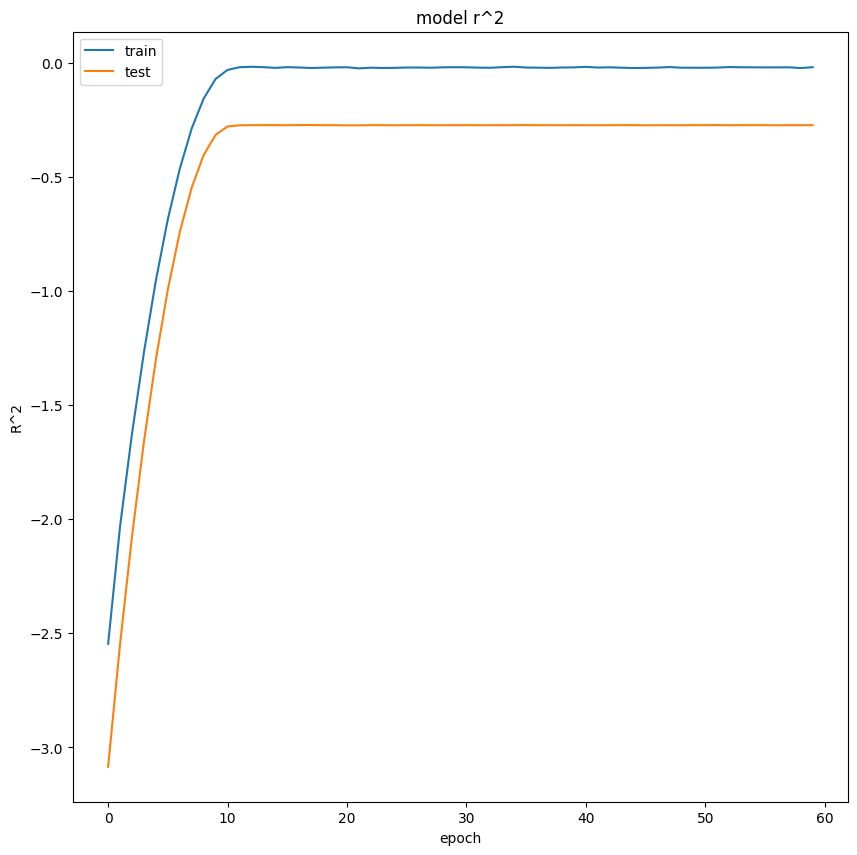

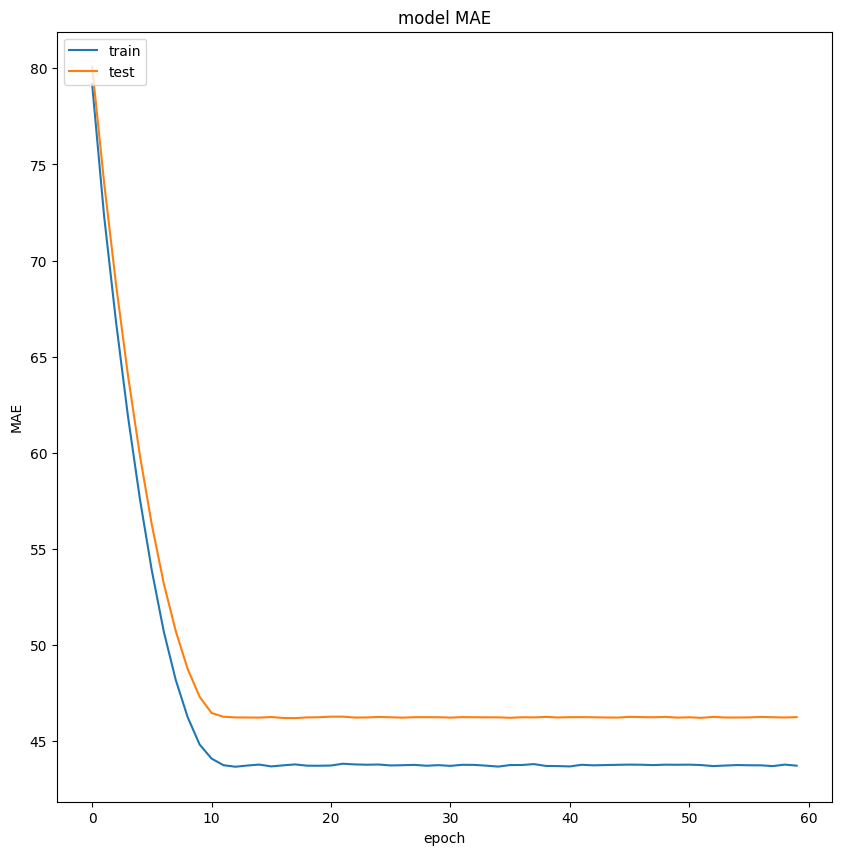

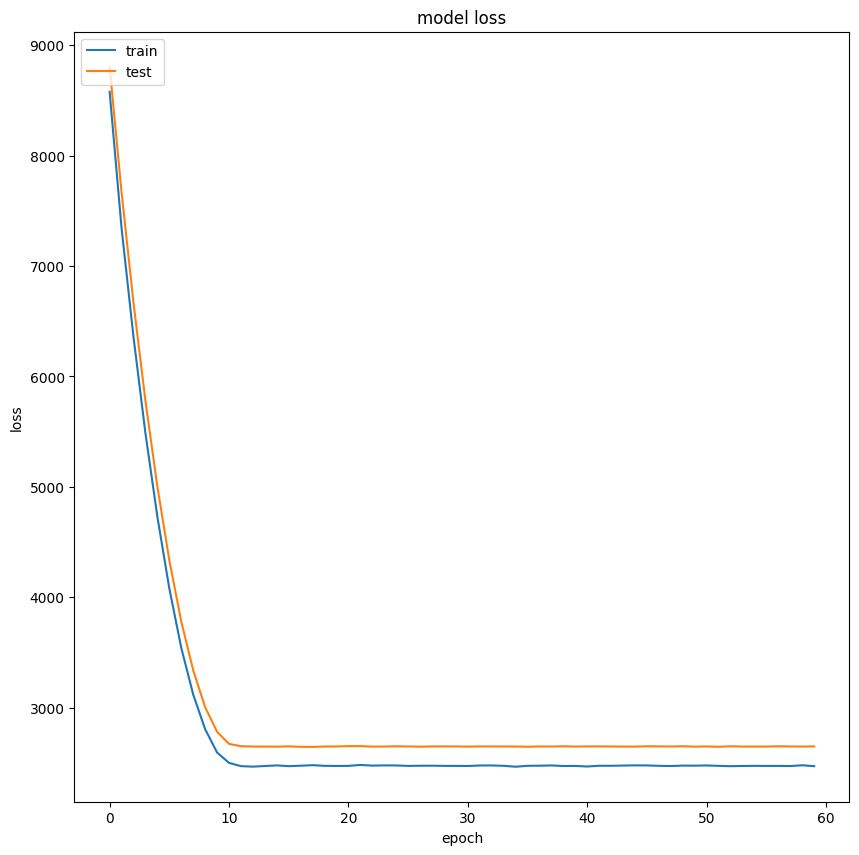

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8069.0986 - mae: 89.8282 - r2_keras: -10973973839872.0000 

MAE: 89.82816314697266

R^2: -8391862779904.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step

Scoring Function: 207.97388586698787

Average Scoring Function: 0.9998744512835955
test set RMSE: 89.83, R2: 0.00, Scoring Function: 207.97, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(89.82817, 0.0, 207.97388585779257, 0.9998744512393873)

In [53]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [54]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2959.2693 - mae: 45.9171 - r2_keras: -0.0327 

MAE: 46.01020050048828

R^2: -0.024794399738311768
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 220.82001972413028
test set RMSE: 54.47, R2: -0.03, Scoring Function: 220.82, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(54.46887, -0.025827975660019264, 220.82001975732763, 0.8525869488699909)

In [55]:
Results=pd.concat([Results,pd.DataFrame({'Model':['Add-1-more-LSTM-Layer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339
3,increase-LSTM-units-do-without-regularizer,89.620949,0.0,207.973339,54.436371,-0.024604,220.772615
4,Add-1-more-LSTM-Layer,89.828171,0.0,207.973886,54.468868,-0.025828,220.820020


## 6. Use Adam optimizer

In [56]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True,
        ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))

    # Compile the model with the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae', r2_keras])

    print(model.summary())

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Fit the network
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2,
                        callbacks=[early_stopping, reduce_lr])

    # List all data in history
    print(history.history.keys())
    
    return model, history

In [57]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,851 (315.82 KB)

 Trainable params: 80,551 (314.65 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/60
188/188 - 5s - 28ms/step - loss: 9865.5908 - mae: 88.6710 - r2_keras: -3.0884e+00 - val_loss: 15190.8770 - val_mae: 113.4696 - val_r2_keras: -7.5852e+01 - learning_rate: 0.0010
Epoch 2/60
188/188 - 2s - 8ms/step - loss: 7482.4536 - mae: 80.4442 - r2_keras: -2.1021e+00 - val_loss: 18811.0332 - val_mae: 129.6424 - val_r2_keras: -9.1275e+01 - learning_rate: 0.0010
Epoch 3/60
188/188 - 1s - 7ms/step - loss: 5284.4541 - mae: 66.9952 - r2_keras: -1.1930e+00 - val_loss: 3981.5195 - val_mae: 57.4799 - val_r2_keras: -2.0872e+01 - learning_rate: 0.0010
Epoch 4/60
188/188 - 1s - 7ms/step - loss: 3234.7478 - mae: 50.5409 - r2_keras: -3.4026e-01 - val_loss: 1362.4384 - val_mae: 32.9459 - val_r2_keras: -7.2415e+00 - learning_rate: 0.0010
Epoch 5/60
188/188 - 1s - 7ms/step - loss: 1745.1511 - mae: 35.3511 - r2_keras: 0.2762 - val_loss: 1304.5919 - val_mae: 29.8784 - val_r2_keras: -1.3098e+00 - learning_rate: 0.0010
Epoch 6/60
188/188 - 1s - 7ms/step - loss: 1025.5747 - mae: 26.3173 - 

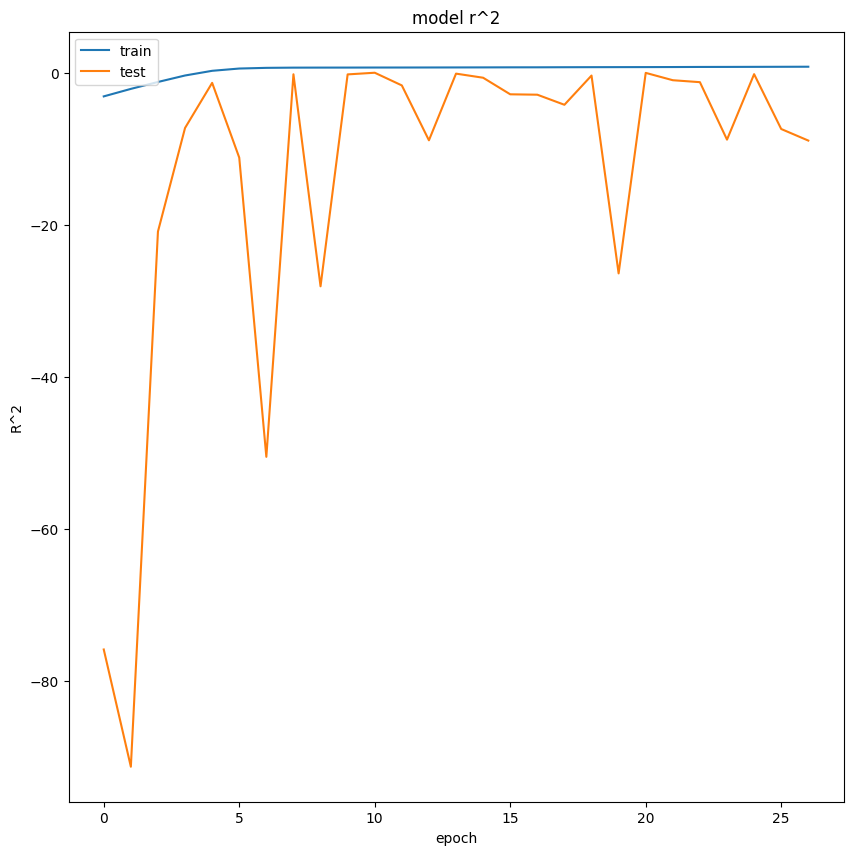

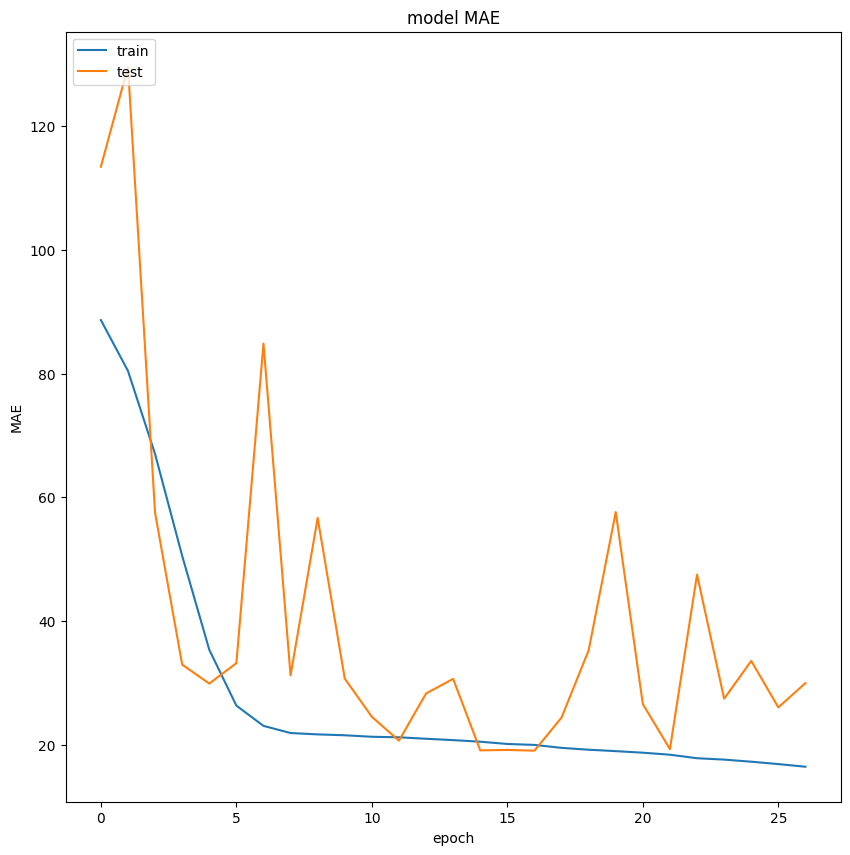

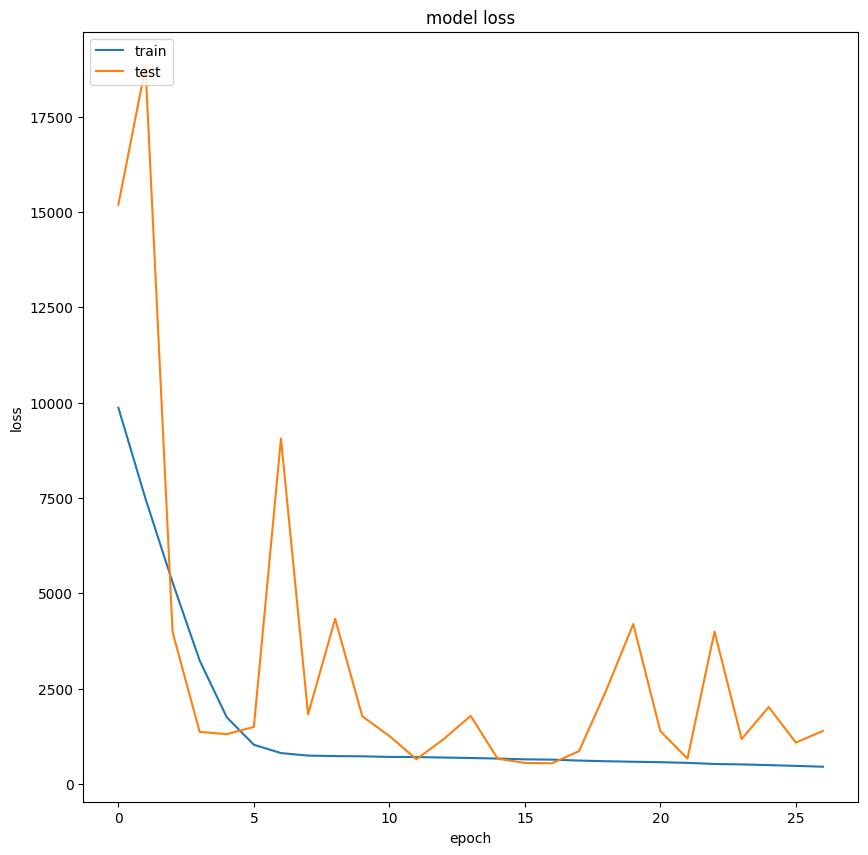

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 239.2917 - mae: 14.9892 - r2_keras: -324974936064.0000 

MAE: 15.008286476135254

R^2: -249613713408.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step

Scoring Function: 158.12741847818492

Average Scoring Function: 0.7602279734528121
test set RMSE: 15.49, R2: 0.00, Scoring Function: 158.13, Average Scoring Function: 0.76


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(15.492359, 0.0, 158.12741830010967, 0.7602279725966811)

In [58]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [59]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1007.4799 - mae: 22.3629 - r2_keras: 0.6242

MAE: 22.70613670349121

R^2: 0.6032498478889465
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 175.61776809969916
test set RMSE: 32.29, R2: 0.64, Scoring Function: 175.62, Average Scoring Function: 0.68


/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)
/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(32.28618, 0.6395781129957123, 175.6177681037335, 0.6780608807093957)

In [60]:
Results=pd.concat([Results,pd.DataFrame({'Model':['Adam-Optimizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339
3,increase-LSTM-units-do-without-regularizer,89.620949,0.0,207.973339,54.436371,-0.024604,220.772615
4,Add-1-more-LSTM-Layer,89.828171,0.0,207.973886,54.468868,-0.025828,220.820020
5,Adam-Optimizer,15.492359,0.0,158.127418,32.286179,0.639578,175.617768


## 7. Use Adam optimizer + increase dropout rate to 0.5

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True,
        ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))

    # Compile the model with the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae', r2_keras])

    print(model.summary())

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Fit the network
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2,
                        callbacks=[early_stopping, reduce_lr])

    # List all data in history
    print(history.history.keys())
    
    return model, history

In [62]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 20, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 20, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,851 (315.82 KB)

 Trainable params: 80,551 (314.65 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/60
188/188 - 4s - 22ms/step - loss: 10116.7363 - mae: 88.8207 - r2_keras: -3.1936e+00 - val_loss: 8827.2441 - val_mae: 81.5415 - val_r2_keras: -4.7288e+01 - learning_rate: 0.0010
Epoch 2/60
188/188 - 1s - 7ms/step - loss: 7706.4526 - mae: 80.1852 - r2_keras: -2.1922e+00 - val_loss: 4189.8335 - val_mae: 53.9942 - val_r2_keras: -2.3809e+01 - learning_rate: 0.0010
Epoch 3/60
188/188 - 1s - 7ms/step - loss: 5220.6118 - mae: 65.7943 - r2_keras: -1.1625e+00 - val_loss: 1926.2371 - val_mae: 37.9940 - val_r2_keras: -9.4874e+00 - learning_rate: 0.0010
Epoch 4/60
188/188 - 1s - 8ms/step - loss: 3180.8652 - mae: 49.4475 - r2_keras: -3.2057e-01 - val_loss: 14293.4629 - val_mae: 111.3095 - val_r2_keras: -7.2852e+01 - learning_rate: 0.0010
Epoch 5/60
188/188 - 1s - 7ms/step - loss: 1765.1663 - mae: 35.1262 - r2_keras: 0.2649 - val_loss: 957.9108 - val_mae: 27.8736 - val_r2_keras: -4.8001e+00 - learning_rate: 0.0010
Epoch 6/60
188/188 - 1s - 7ms/step - loss: 1087.9507 - mae: 27.0289 - r2

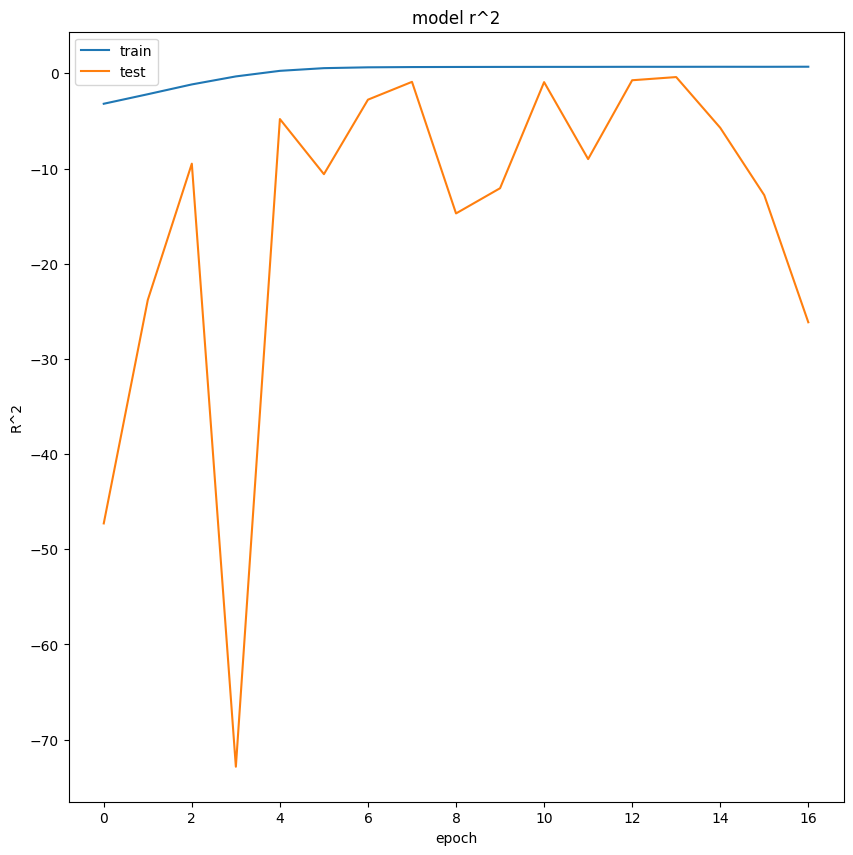

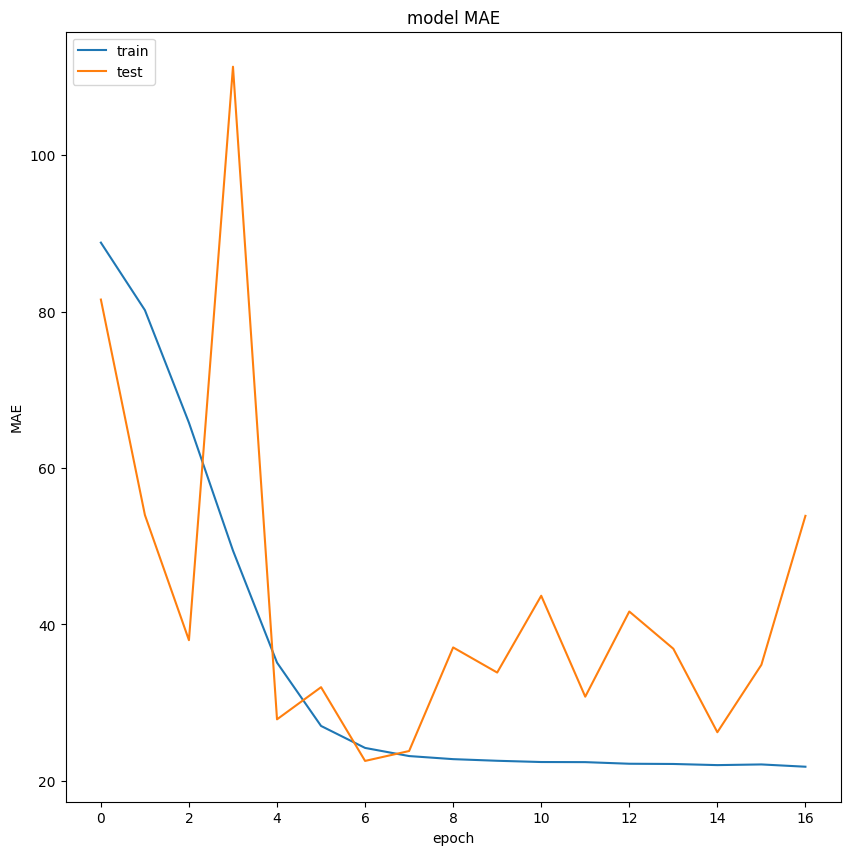

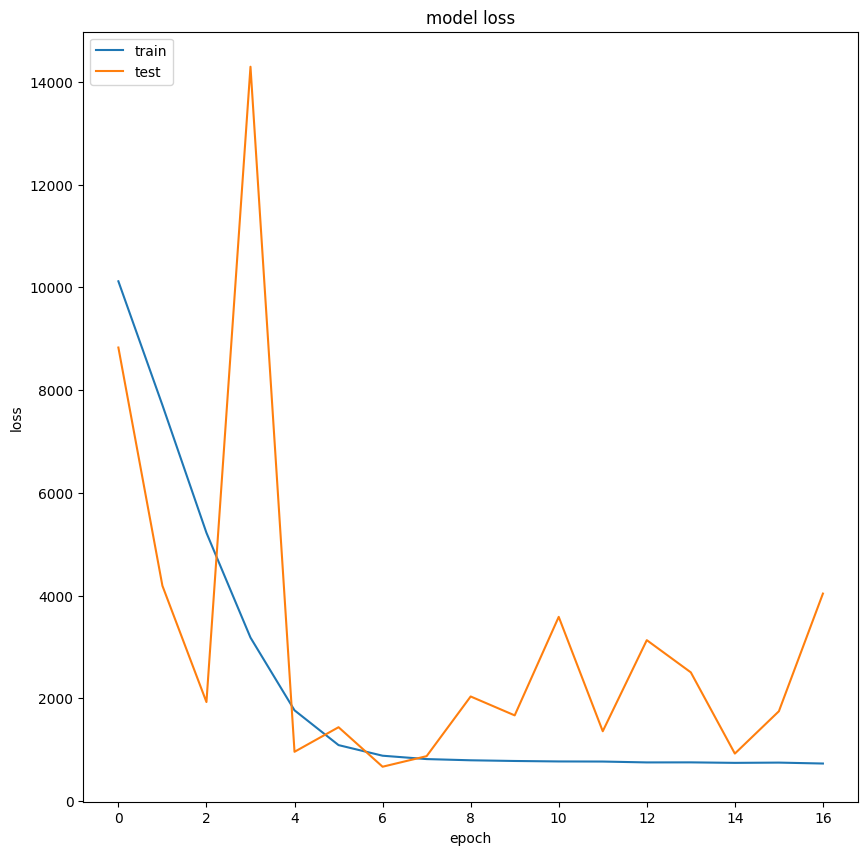

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 160.2330 - mae: 10.4184 - r2_keras: -217346228224.0000 

MAE: 10.450760841369629

R^2: -167569588224.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step

Scoring Function: 116.43521637030918

Average Scoring Function: 0.5597846940880249
test set RMSE: 12.69, R2: 0.00, Scoring Function: 116.44, Average Scoring Function: 0.56


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(12.693487, 0.0, 116.43521626846103, 0.5597846935983704)

In [63]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [64]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 947.1790 - mae: 22.1678 - r2_keras: 0.6593 

MAE: 22.4635066986084

R^2: 0.6519390344619751
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

Scoring Function: 172.23616041466624
test set RMSE: 31.03, R2: 0.67, Scoring Function: 172.24, Average Scoring Function: 0.67


/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)
/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(31.034744, 0.666977003606226, 172.23616043709774, 0.6650044804521148)

In [65]:
Results=pd.concat([Results,pd.DataFrame({'Model':['Adam-Optimizer-+-increase-dropout-rate-to-0.5'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339
3,increase-LSTM-units-do-without-regularizer,89.620949,0.0,207.973339,54.436371,-0.024604,220.772615
4,Add-1-more-LSTM-Layer,89.828171,0.0,207.973886,54.468868,-0.025828,220.820020
5,Adam-Optimizer,15.492359,0.0,158.127418,32.286179,0.639578,175.617768
6,Adam-Optimizer-+-increase-dropout-rate-to-0.5,12.693487,0.0,116.435216,31.034744,0.666977,172.236160


# Train using padding, increase window size to 50

Execute LSTM data preprocessing on train and test data, with padding.

In [66]:
seq_array, label_array, X_train_split_scaled, sequence_length, sequence_cols = lstm_data_preprocessing(X_train_split_scaled, y_train_clipped_split_scaled, sequence_length = 50, padding = True)

seq_array:
 (33272, 50, 24)

label_array:
 (33272, 1)


In [67]:
seq_array, label_array, X_train_split_scaled, sequence_length, sequence_cols = lstm_data_preprocessing(X_train_split_scaled, y_train_clipped_split_scaled, sequence_length = 50, padding = True)
test_seq_array, test_label_array, X_test_split_scaled, test_sequence_length, test_sequence_cols = lstm_data_preprocessing(X_test_scaled, y_test, sequence_length = 50, padding = True)

seq_array:
 (33272, 50, 24)

label_array:
 (33272, 1)
seq_array:
 (21608, 50, 24)

label_array:
 (21608, 1)


## 1. Baseline Training

In [68]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

 
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
    
    # list all data in history
    print(history.history.keys())
    
    return model, history

In [69]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
159/159 - 3s - 20ms/step - loss: 6881.4819 - mae: 69.1511 - r2_keras: -2.1184e+00 - val_loss: 8092.9868 - val_mae: 75.1436 - val_r2_keras: -4.1827e+00
Epoch 2/60
159/159 - 1s - 8ms/step - loss: 5795.4771 - mae: 62.4467 - r2_keras: -1.6038e+00 - val_loss: 6982.4395 - val_mae: 69.1833 - val_r2_keras: -3.4061e+00
Epoch 3/60
159/159 - 1s - 8ms/step - loss: 4904.8398 - mae: 56.9742 - r2_keras: -1.2042e+00 - val_loss: 6000.5010 - val_mae: 63.9456 - val_r2_keras: -2.7619e+00
Epoch 4/60
159/159 - 1s - 8ms/step - loss: 4149.3315 - mae: 52.3347 - r2_keras: -8.6617e-01 - val_loss: 5146.8154 - val_mae: 59.4017 - val_r2_keras: -2.2500e+00
Epoch 5/60
159/159 - 1s - 8ms/step - loss: 3523.2258 - mae: 48.5168 - r2_keras: -5.8148e-01 - val_loss: 4427.4951 - val_mae: 55.5840 - val_r2_keras: -1.8732e+00
Epoch 6/60
159/159 - 1s - 8ms/step - loss: 3019.9705 - mae: 45.4636 - r2_keras: -3.5570e-01 - val_loss: 3834.7092 - val_mae: 52.4505 - val_r2_keras: -1.6264e+00
Epoch 7/60
159/159 - 1s - 8m

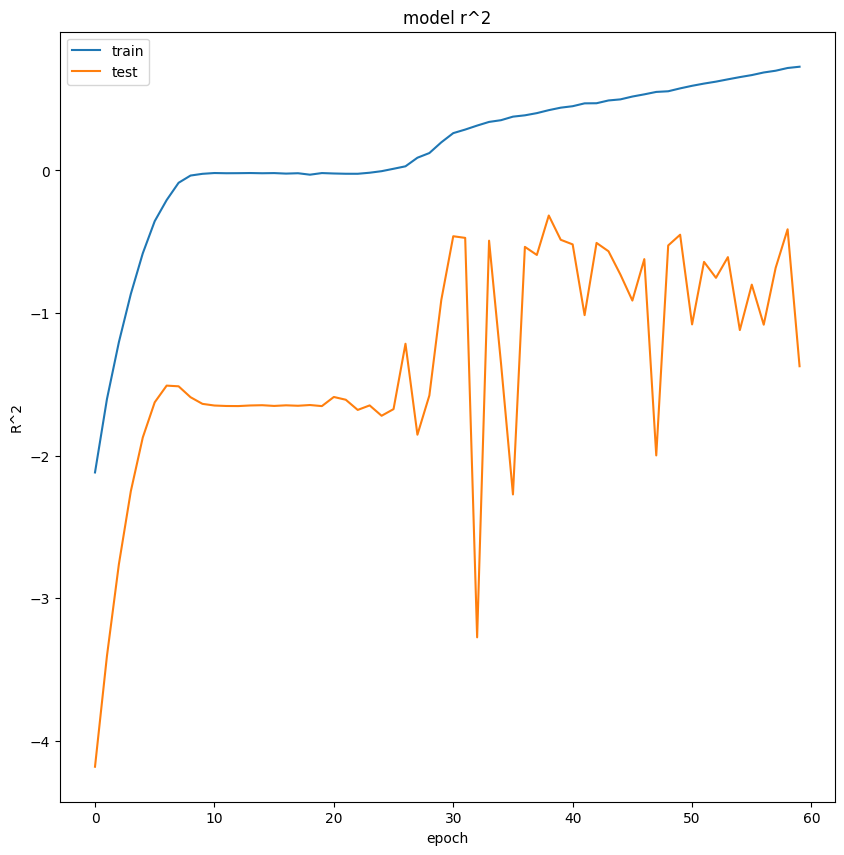

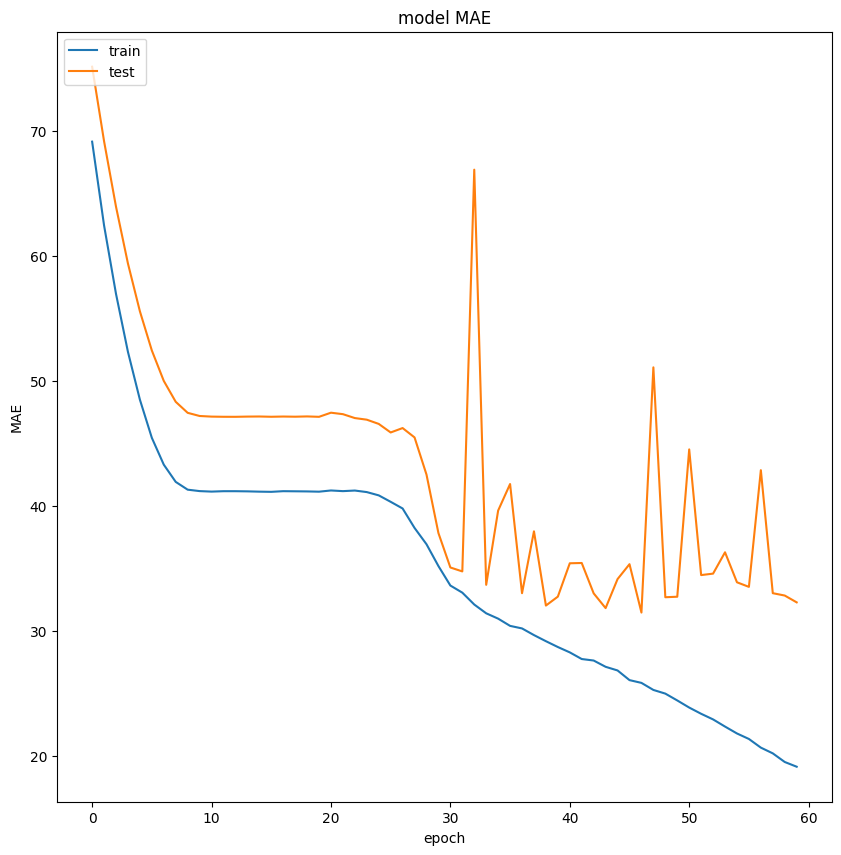

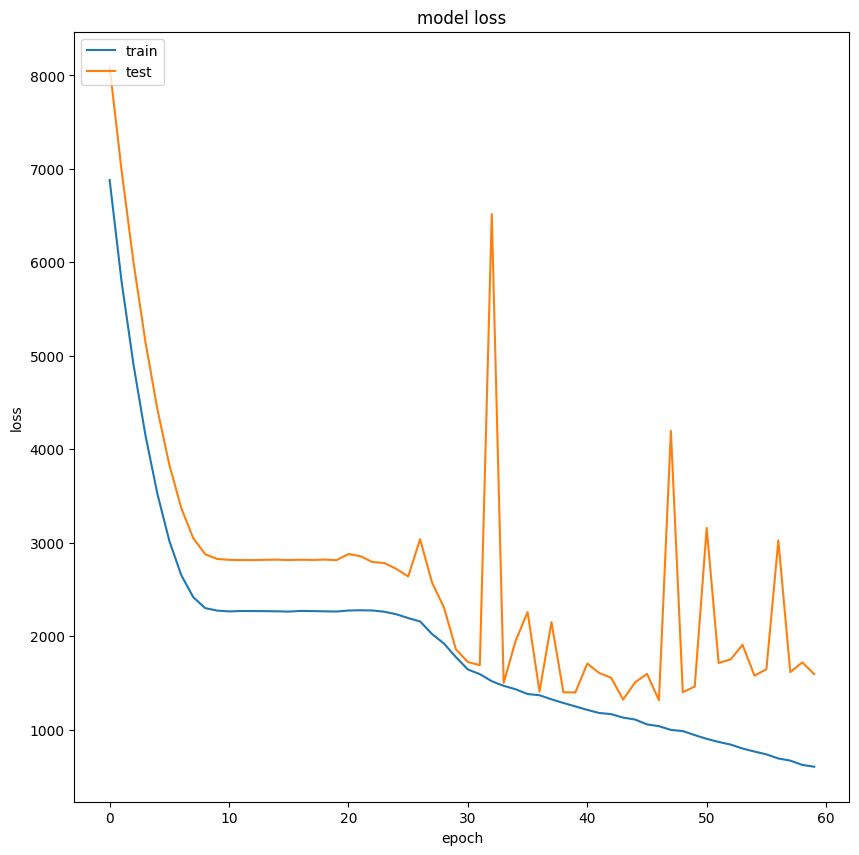

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1106.4249 - mae: 26.9159 - r2_keras: -1505618427904.0000 

MAE: 26.91571044921875

R^2: -1149250568192.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step

Scoring Function: 170.22216833408817

Average Scoring Function: 0.8183758092985008
test set RMSE: 33.24, R2: 0.00, Scoring Function: 170.22, Average Scoring Function: 0.82


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(33.24227, 0.0, 170.22216834682916, 0.8183758093597556)

In [70]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [71]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2207.0312 - mae: 38.5612 - r2_keras: 0.2314 

MAE: 38.67689895629883

R^2: 0.23885327577590942
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 218.16690397323495
test set RMSE: 47.02, R2: 0.24, Scoring Function: 218.17, Average Scoring Function: 0.84


/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)
/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(47.01663, 0.23567005988214595, 218.1669037802095, 0.8423432578386467)

In [72]:
Results_pad=pd.DataFrame({'Model':['LSTM-Baseline'],
                          'RMSE-Train':[RMSE_Train],
                          'R2-Train':[R2_Train],
                          'Score-Train':[Score_Train],             
                          'RMSE-Test':[RMSE_Test],
                          'R2-Test':[R2_Test],
                          'Score-Test':[Score_Test]})
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.23567,218.166904


## 2. Increase dropout from 0.2 to 0.5

In [73]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())

def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True))
    model.add(Dropout(0.5))
    model.add(LSTM(
              units=50,
              return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2)
   
    # list all data in history
    print(history.history.keys())
    
    return model, history

In [74]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
159/159 - 3s - 20ms/step - loss: 6857.5640 - mae: 69.0002 - r2_keras: -2.0845e+00 - val_loss: 8052.8291 - val_mae: 74.9260 - val_r2_keras: -4.1539e+00
Epoch 2/60
159/159 - 1s - 8ms/step - loss: 5771.9717 - mae: 62.2906 - r2_keras: -1.5998e+00 - val_loss: 6948.5059 - val_mae: 69.0014 - val_r2_keras: -3.3830e+00
Epoch 3/60
159/159 - 1s - 8ms/step - loss: 4896.9722 - mae: 56.9458 - r2_keras: -1.1987e+00 - val_loss: 5977.1260 - val_mae: 63.8202 - val_r2_keras: -2.7472e+00
Epoch 4/60
159/159 - 1s - 8ms/step - loss: 4149.7231 - mae: 52.3414 - r2_keras: -8.6425e-01 - val_loss: 5130.7402 - val_mae: 59.3156 - val_r2_keras: -2.2410e+00
Epoch 5/60
159/159 - 1s - 8ms/step - loss: 3534.4443 - mae: 48.5735 - r2_keras: -6.0287e-01 - val_loss: 4413.9019 - val_mae: 55.5114 - val_r2_keras: -1.8668e+00
Epoch 6/60
159/159 - 1s - 8ms/step - loss: 3060.4338 - mae: 45.7636 - r2_keras: -3.7595e-01 - val_loss: 3834.0583 - val_mae: 52.4470 - val_r2_keras: -1.6261e+00
Epoch 7/60
159/159 - 1s - 8m

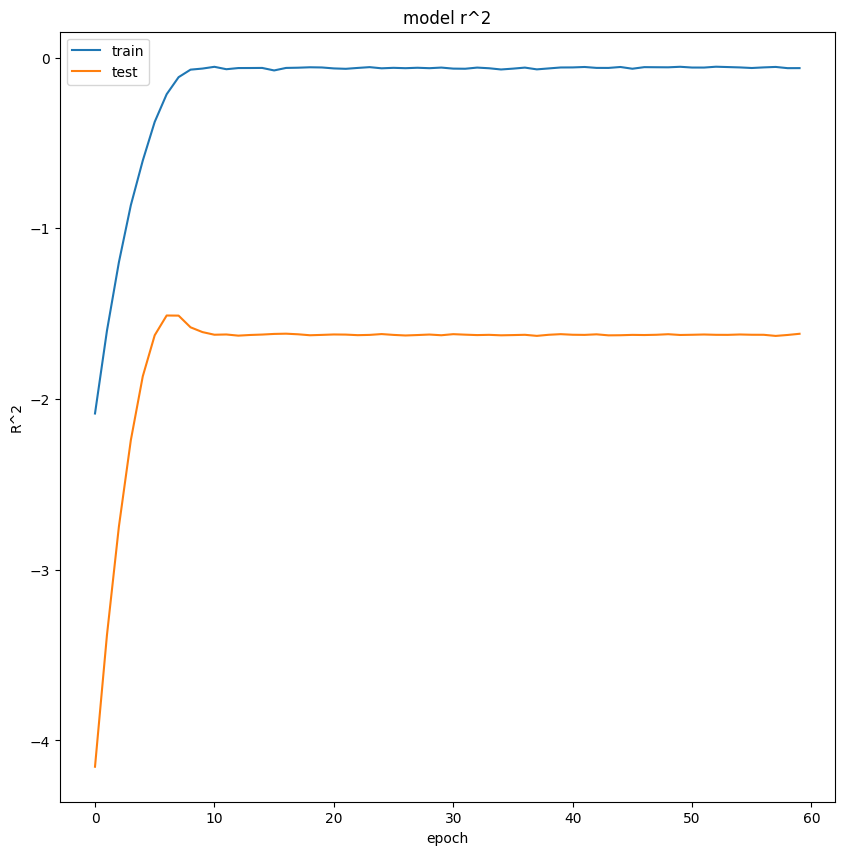

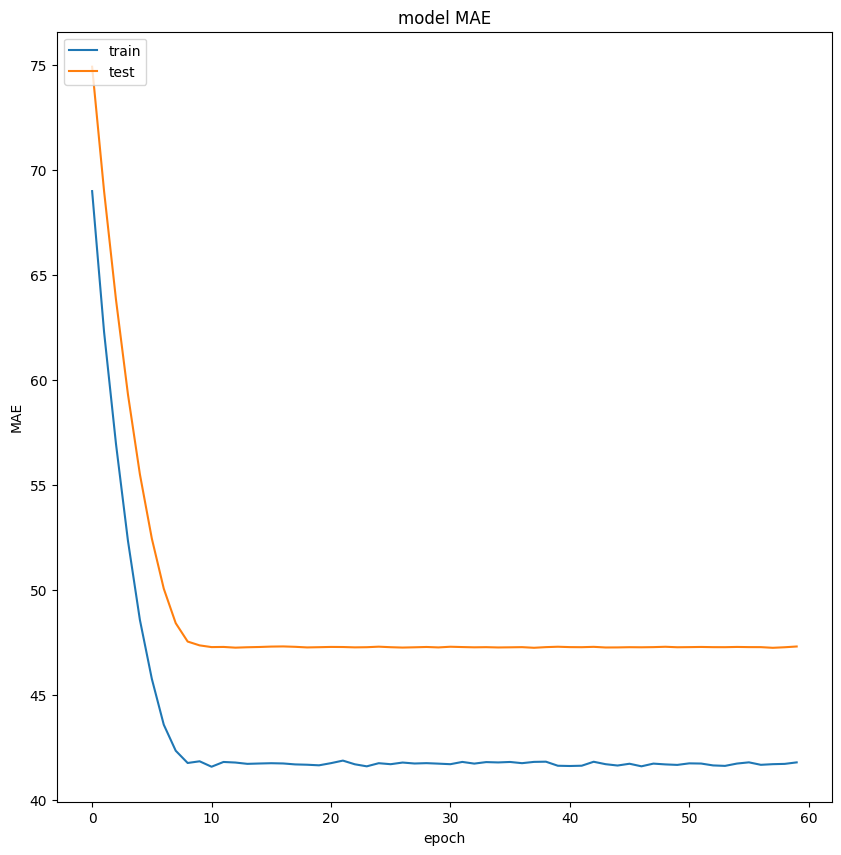

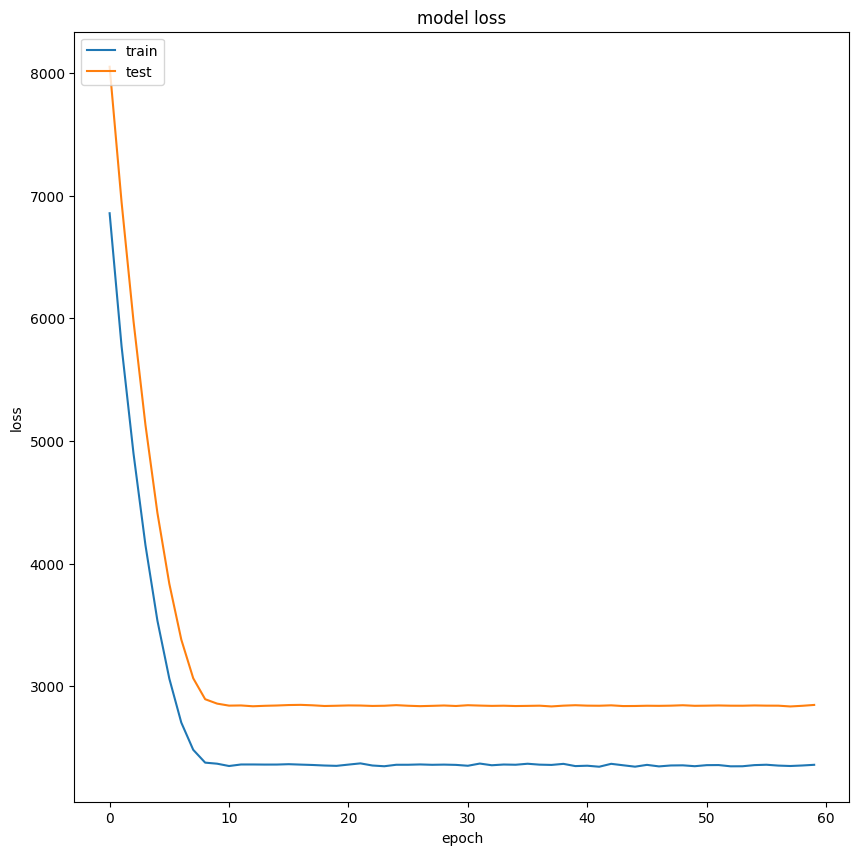

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6172.4609 - mae: 78.5650 - r2_keras: -8394546610176.0000  

MAE: 78.56501007080078

R^2: -6419359203328.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step

Scoring Function: 207.91945692793072

Average Scoring Function: 0.9996127736919747
test set RMSE: 78.57, R2: 0.00, Scoring Function: 207.92, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(78.56502, 0.0, 207.91945692937105, 0.9996127736988993)

In [75]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [76]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2868.5718 - mae: 45.0587 - r2_keras: -0.0184     

MAE: 45.308067321777344

R^2: -0.027576565742492676
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 220.0104753955462
test set RMSE: 53.84, R2: -0.00, Scoring Function: 220.01, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(53.8426, -0.0023744573703430305, 220.01047545093002, 0.8494612951773359)

In [77]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['increase-dropout-from-0.2-to-0.5'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475


## 3. Add kernel regularizer

In [78]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=100,
             return_sequences=True,
            kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=50,
              return_sequences=False,
                kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out, kernel_regularizer=l2(0.01)))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())
    history = model.fit(seq_array, label_array, epochs=60, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [79]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_19 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,251 (313.48 KB)

 Trainable params: 80,251 (313.48 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
124/124 - 4s - 29ms/step - loss: 7009.6826 - mae: 69.9433 - r2_keras: -2.1496e+00 - val_loss: 8322.8604 - val_mae: 76.3807 - val_r2_keras: -2.3011e+00
Epoch 2/60
124/124 - 1s - 9ms/step - loss: 6086.7090 - mae: 64.2215 - r2_keras: -1.7323e+00 - val_loss: 7422.7812 - val_mae: 71.5364 - val_r2_keras: -1.9262e+00
Epoch 3/60
124/124 - 1s - 9ms/step - loss: 5351.7495 - mae: 59.7138 - r2_keras: -1.4044e+00 - val_loss: 6602.9600 - val_mae: 67.1572 - val_r2_keras: -1.5871e+00
Epoch 4/60
124/124 - 1s - 9ms/step - loss: 4694.9712 - mae: 55.6799 - r2_keras: -1.1091e+00 - val_loss: 5862.0146 - val_mae: 63.2057 - val_r2_keras: -1.2836e+00
Epoch 5/60
124/124 - 1s - 9ms/step - loss: 4119.4150 - mae: 52.1486 - r2_keras: -8.5176e-01 - val_loss: 5201.0303 - val_mae: 59.6883 - val_r2_keras: -1.0160e+00
Epoch 6/60
124/124 - 1s - 9ms/step - loss: 3618.2100 - mae: 49.0963 - r2_keras: -6.2281e-01 - val_loss: 4620.1460 - val_mae: 56.6032 - val_r2_keras: -7.8452e-01
Epoch 7/60
124/124 - 1s - 9m

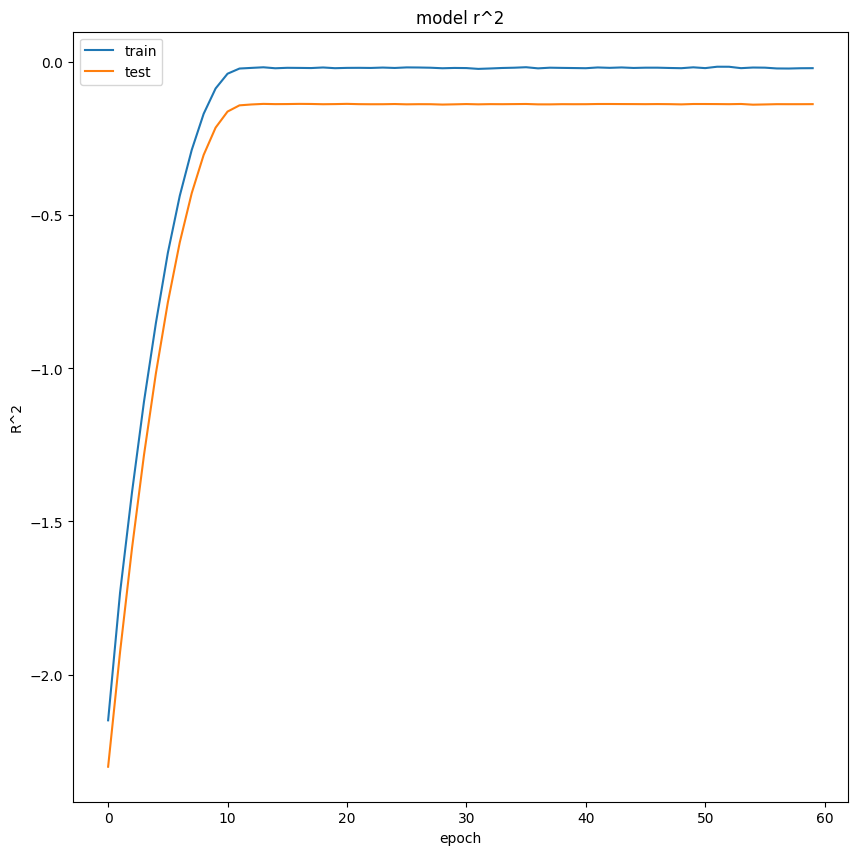

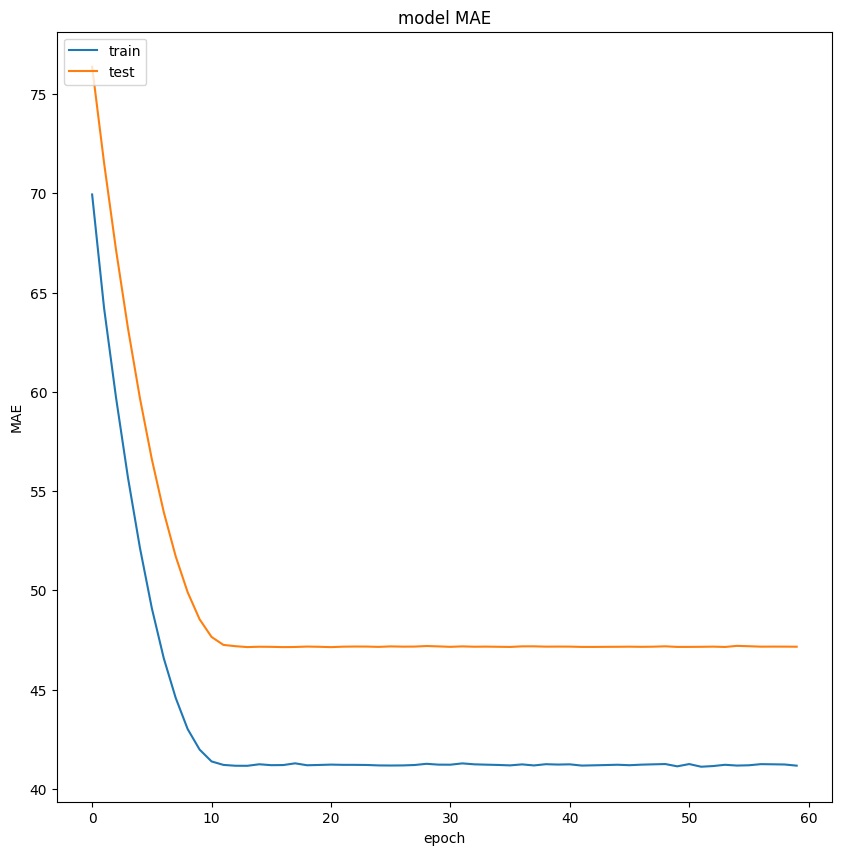

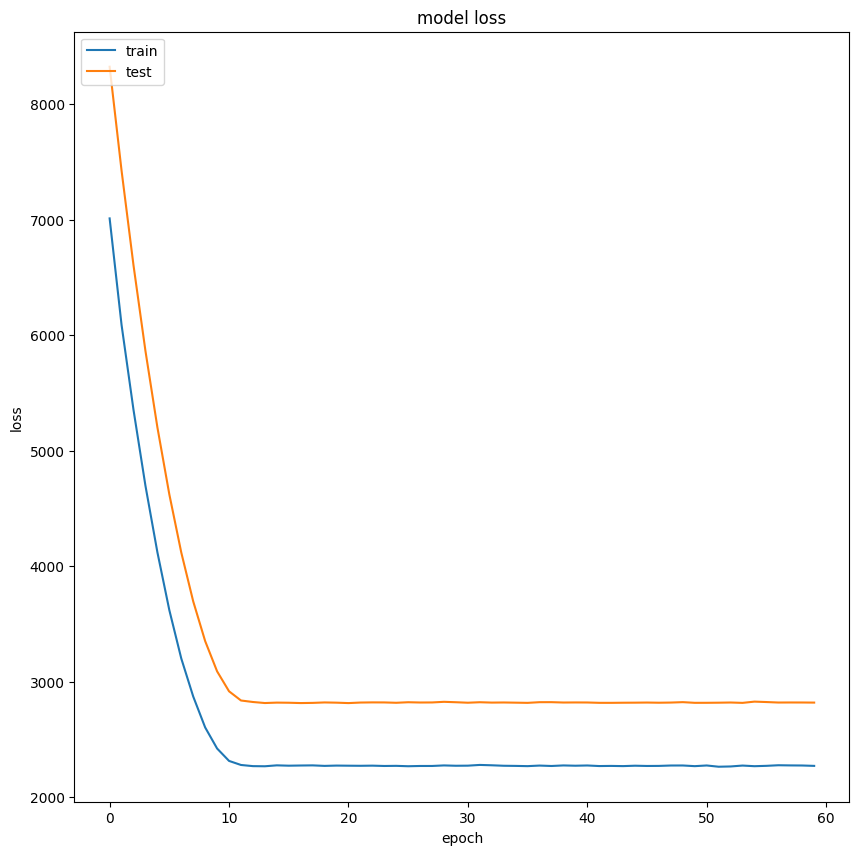

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6389.5908 - mae: 79.9273 - r2_keras: -8688197173248.0000  

MAE: 79.92733764648438

R^2: -6643915423744.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step

Scoring Function: 207.92971496204495

Average Scoring Function: 0.9996620911636777
test set RMSE: 79.93, R2: 0.00, Scoring Function: 207.93, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(79.927345, 0.0, 207.92971496797495, 0.9996620911921872)

In [80]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [81]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2867.2634 - mae: 45.0516 - r2_keras: -0.0155 

MAE: 45.27883529663086

R^2: -0.022619903087615967
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 219.54138699880158
test set RMSE: 53.79, R2: -0.00, Scoring Function: 219.54, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(53.793507, -0.0005471888959938109, 219.54138691999785, 0.8476501425482542)

In [82]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['add-kernel-regularizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387


## 4. Increase LSTM units, do without regularizer

In [83]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
             input_shape=(sequence_length, nb_features),
             units=200,
             return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
              units=100,
              return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())
    history = model.fit(seq_array, label_array, epochs=20, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [84]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 50, 200)        │       180,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 50, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 100)            │       120,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │           101 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 300,501 (1.15 MB)

 Trainable params: 300,501 (1.15 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
124/124 - 4s - 30ms/step - loss: 6173.3105 - mae: 64.7595 - r2_keras: -1.7690e+00 - val_loss: 7013.4111 - val_mae: 69.3490 - val_r2_keras: -1.7566e+00
Epoch 2/20
124/124 - 2s - 16ms/step - loss: 4722.1582 - mae: 55.8488 - r2_keras: -1.1217e+00 - val_loss: 5554.4370 - val_mae: 61.5699 - val_r2_keras: -1.1587e+00
Epoch 3/20
124/124 - 2s - 16ms/step - loss: 3657.3643 - mae: 49.3259 - r2_keras: -6.3951e-01 - val_loss: 4402.5581 - val_mae: 55.4508 - val_r2_keras: -6.9919e-01
Epoch 4/20
124/124 - 2s - 16ms/step - loss: 2898.5171 - mae: 44.7566 - r2_keras: -3.0009e-01 - val_loss: 3562.1475 - val_mae: 51.0150 - val_r2_keras: -3.7913e-01
Epoch 5/20
124/124 - 2s - 16ms/step - loss: 2446.7578 - mae: 42.1320 - r2_keras: -9.7448e-02 - val_loss: 3031.6187 - val_mae: 48.2499 - val_r2_keras: -1.9565e-01
Epoch 6/20
124/124 - 2s - 16ms/step - loss: 2273.3745 - mae: 41.1920 - r2_keras: -2.0037e-02 - val_loss: 2828.6992 - val_mae: 47.2175 - val_r2_keras: -1.3924e-01
Epoch 7/20
124/124 - 2s

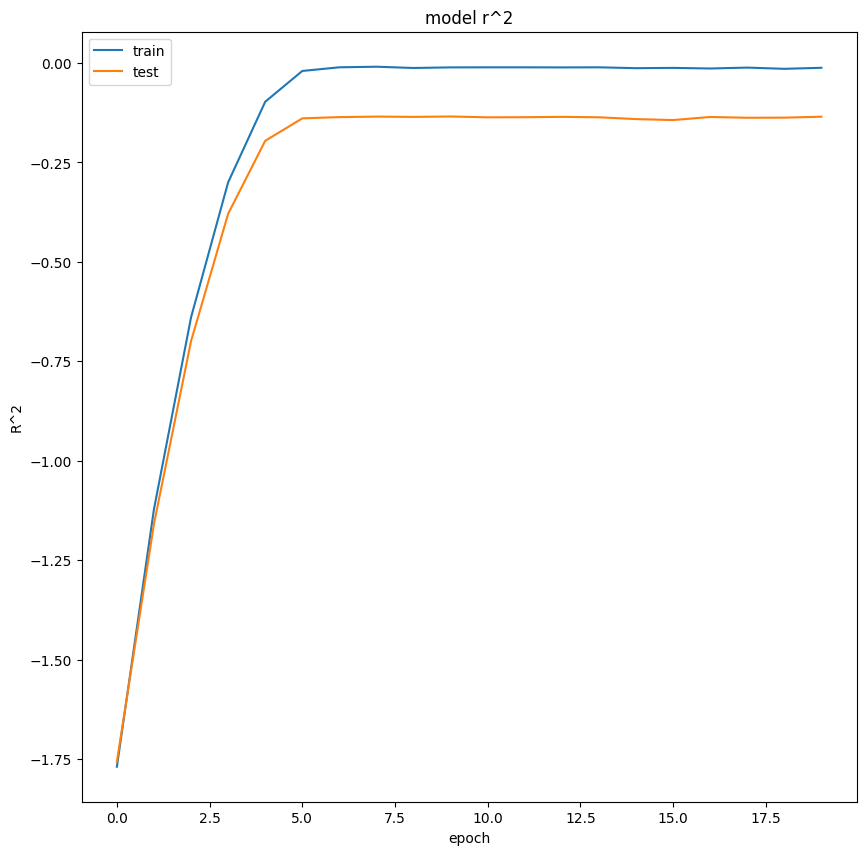

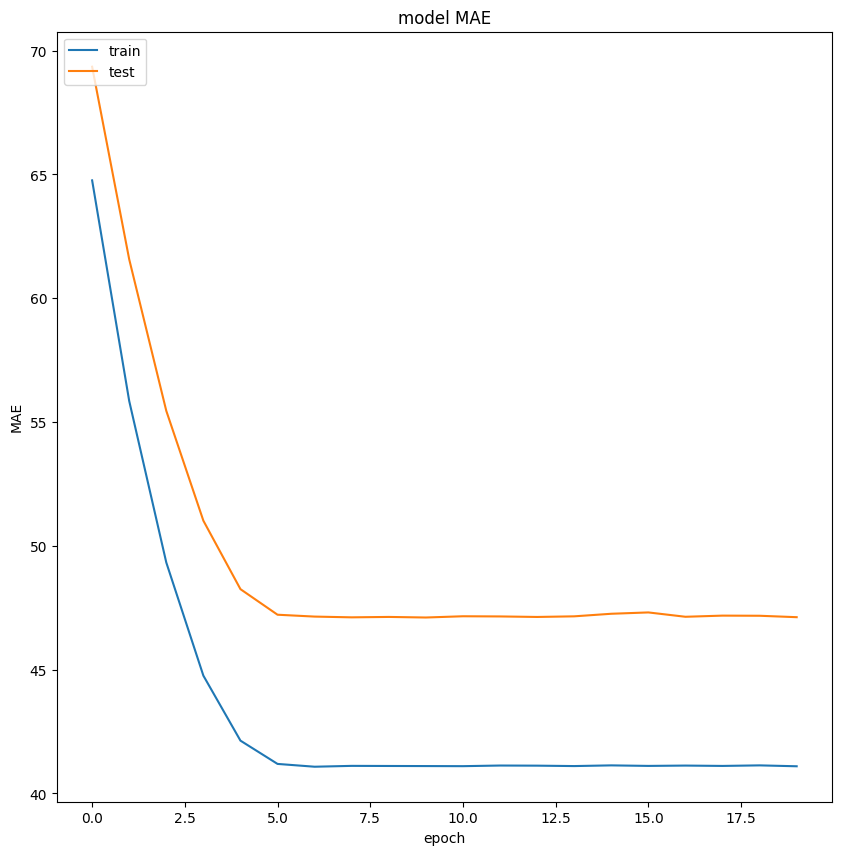

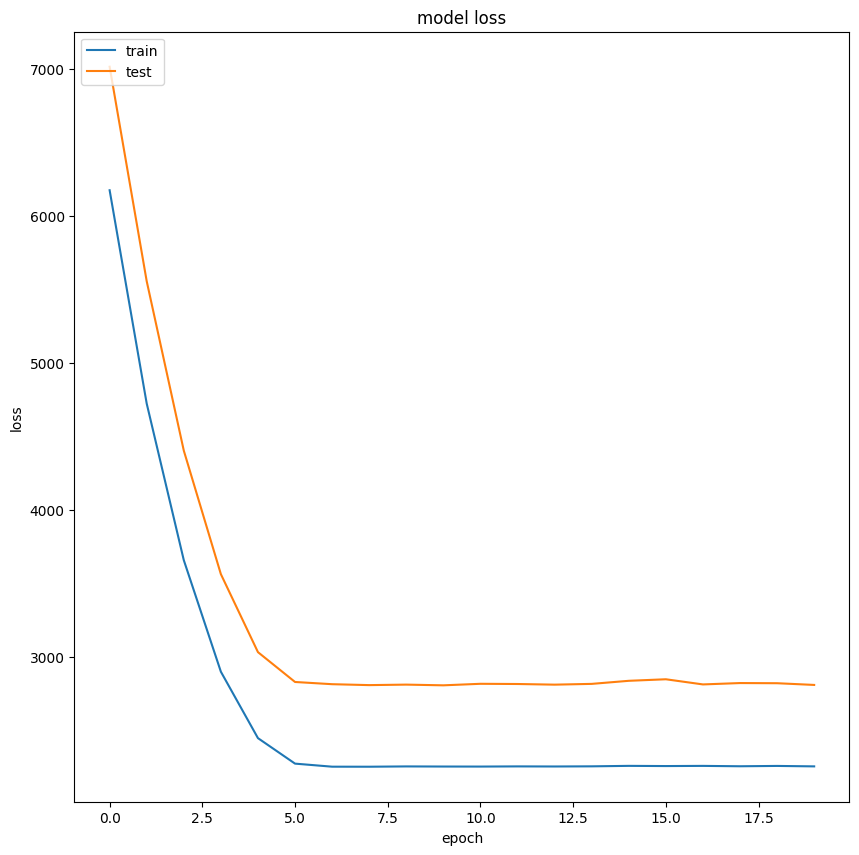

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6452.5723 - mae: 80.3279 - r2_keras: -8775498465280.0000  

MAE: 80.32791137695312

R^2: -6710675111936.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step

Scoring Function: 207.93247466389406

Average Scoring Function: 0.9996753589610291
test set RMSE: 80.33, R2: 0.00, Scoring Function: 207.93, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(80.3279, 0.0, 207.93247466308912, 0.9996753589571592)

In [85]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [86]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2866.0210 - mae: 45.0594 - r2_keras: -0.0148 

MAE: 45.27925491333008

R^2: -0.021404504776000977
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 219.50470718654356
test set RMSE: 53.79, R2: -0.00, Scoring Function: 219.50, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(53.785652, -0.00025497255560313903, 219.5047072635978, 0.8475085222532733)

In [87]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['increase-LSTM-units-do-without-regularizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387
3,increase-LSTM-units-do-without-regularizer,80.327904,0.0,207.932475,53.785652,-0.000255,219.504707


## 5. Add 1 more LSTM layer

In [88]:
import tensorflow as tf
import keras.backend as K
from keras.optimizers import RMSprop
from keras.regularizers import l2

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):

    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(
        units=50,
        return_sequences=True,
        ))
    model.add(Dropout(0.2))
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.2))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    
    
    model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])

    print(model.summary())

    history = model.fit(seq_array, label_array, epochs=60, batch_size=256, validation_split=0.05, verbose=2)

    # list all data in history
    print(history.history.keys())
    
    return model, history

In [89]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_23 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_24 (LSTM)                  │ (None, 50, 50)         │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_25 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,451 (392.39 KB)

 Trainable params: 100,451 (392.39 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/60
124/124 - 4s - 30ms/step - loss: 7026.4604 - mae: 70.0524 - r2_keras: -2.1591e+00 - val_loss: 8352.2969 - val_mae: 76.5452 - val_r2_keras: -2.3139e+00
Epoch 2/60
124/124 - 1s - 12ms/step - loss: 6103.5151 - mae: 64.3500 - r2_keras: -1.7405e+00 - val_loss: 7449.5449 - val_mae: 71.6809 - val_r2_keras: -1.9374e+00
Epoch 3/60
124/124 - 1s - 12ms/step - loss: 5371.1821 - mae: 59.8323 - r2_keras: -1.4161e+00 - val_loss: 6628.7964 - val_mae: 67.2963 - val_r2_keras: -1.5978e+00
Epoch 4/60
124/124 - 1s - 12ms/step - loss: 4715.1460 - mae: 55.8112 - r2_keras: -1.1204e+00 - val_loss: 5885.0913 - val_mae: 63.3307 - val_r2_keras: -1.2930e+00
Epoch 5/60
124/124 - 1s - 12ms/step - loss: 4134.3599 - mae: 52.2546 - r2_keras: -8.5540e-01 - val_loss: 5221.2109 - val_mae: 59.7965 - val_r2_keras: -1.0243e+00
Epoch 6/60
124/124 - 1s - 12ms/step - loss: 3636.7659 - mae: 49.2267 - r2_keras: -6.3309e-01 - val_loss: 4638.3325 - val_mae: 56.7015 - val_r2_keras: -7.9187e-01
Epoch 7/60
124/124 - 1s

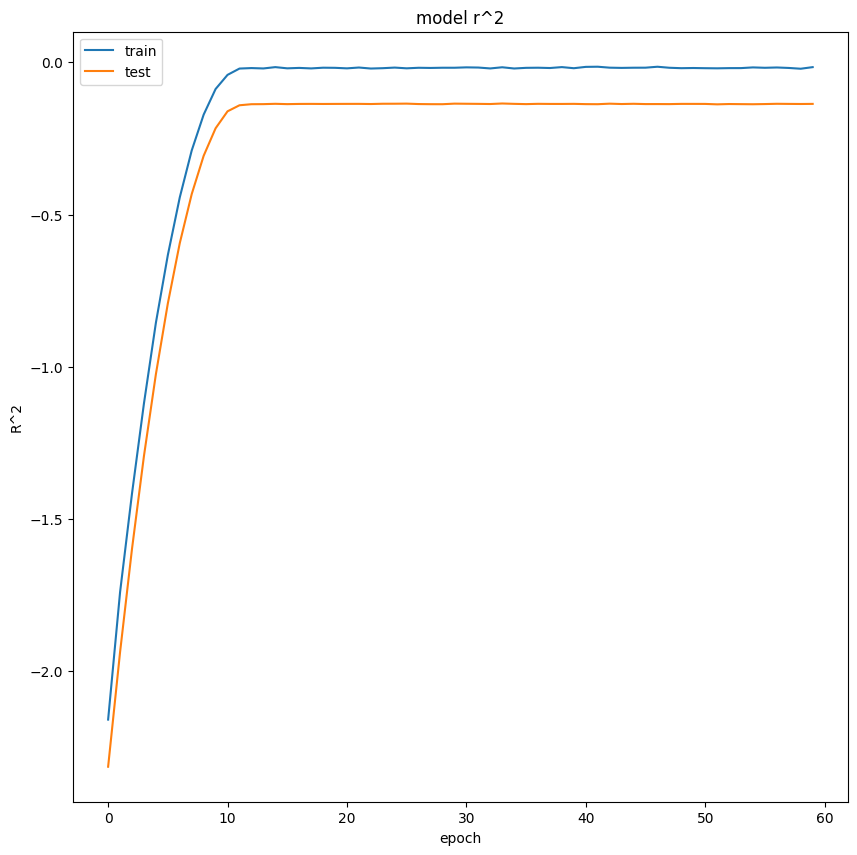

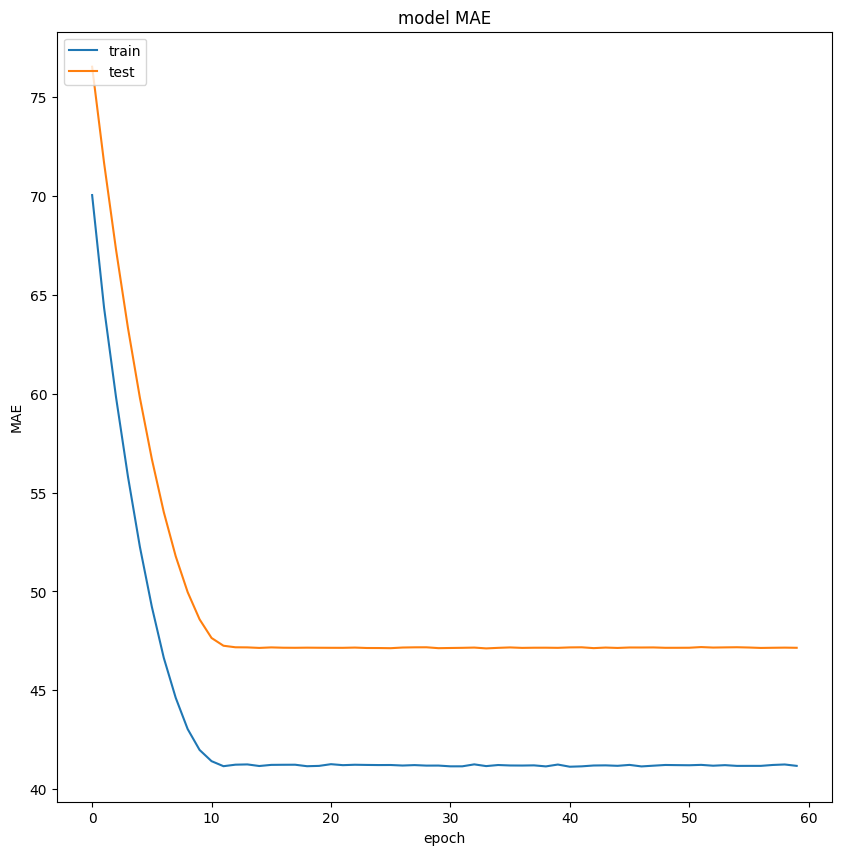

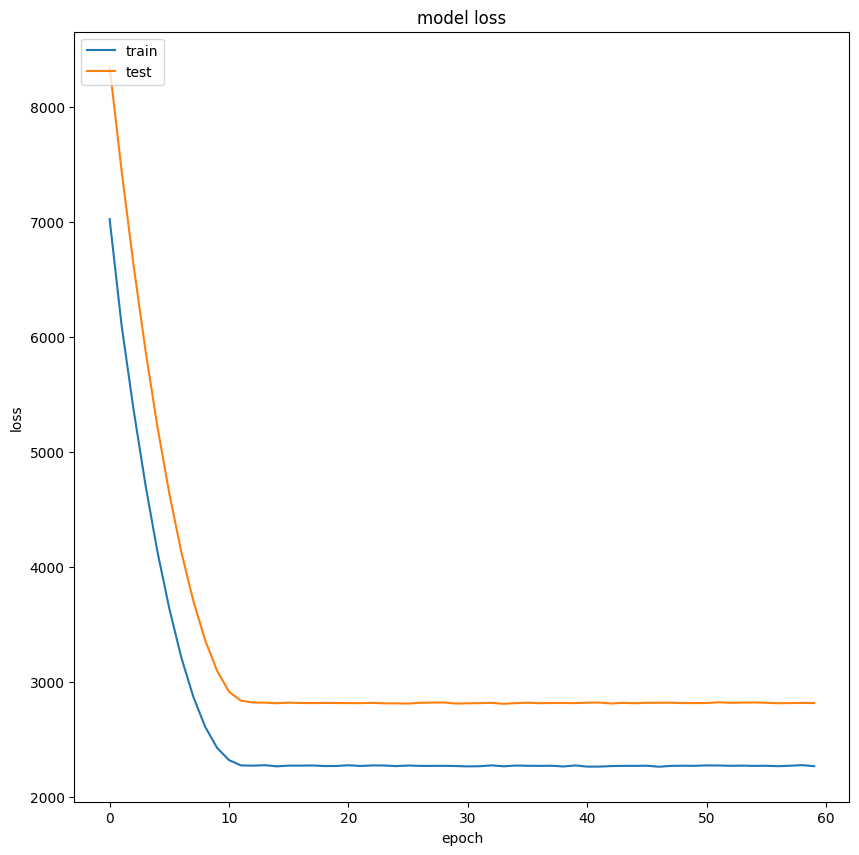

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6398.0049 - mae: 79.9875 - r2_keras: -8701286547456.0000 

MAE: 79.98754119873047

R^2: -6653925130240.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step

Scoring Function: 207.9301367477103

Average Scoring Function: 0.9996641189793765
test set RMSE: 79.99, R2: 0.00, Scoring Function: 207.93, Average Scoring Function: 1.00


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(79.98753, 0.0, 207.93013673515395, 0.9996641189190094)

In [90]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [91]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2866.0271 - mae: 45.0519 - r2_keras: -0.0154 

MAE: 45.27813720703125

R^2: -0.022430241107940674
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 219.521560507225
test set RMSE: 53.79, R2: -0.00, Scoring Function: 219.52, Average Scoring Function: 0.85


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(53.792133, -0.0004960665053388436, 219.52156063300777, 0.8475735931776361)

In [92]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['Add-1-more-LSTM-Layer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387
3,increase-LSTM-units-do-without-regularizer,80.327904,0.0,207.932475,53.785652,-0.000255,219.504707
4,Add-1-more-LSTM-Layer,79.987534,0.0,207.930137,53.792133,-0.000496,219.521561


## 6. Use Adam optimizer

In [93]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True,
        ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))

    # Compile the model with the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae', r2_keras])

    print(model.summary())

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Fit the network
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2,
                        callbacks=[early_stopping, reduce_lr])

    # List all data in history
    print(history.history.keys())
    
    return model, history

In [94]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_26 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 50, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,851 (315.82 KB)

 Trainable params: 80,551 (314.65 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/60
159/159 - 4s - 28ms/step - loss: 8171.6963 - mae: 79.1687 - r2_keras: -2.6761e+00 - val_loss: 8393.9521 - val_mae: 76.8101 - val_r2_keras: -4.4088e+00 - learning_rate: 0.0010
Epoch 2/60
159/159 - 2s - 10ms/step - loss: 6480.9487 - mae: 73.4087 - r2_keras: -1.9216e+00 - val_loss: 11324.6680 - val_mae: 97.2757 - val_r2_keras: -7.3141e+00 - learning_rate: 0.0010
Epoch 3/60
159/159 - 2s - 10ms/step - loss: 4866.0337 - mae: 63.6237 - r2_keras: -1.1864e+00 - val_loss: 2844.7639 - val_mae: 45.5855 - val_r2_keras: -1.5807e+00 - learning_rate: 0.0010
Epoch 4/60
159/159 - 2s - 10ms/step - loss: 3345.2510 - mae: 51.4542 - r2_keras: -5.2363e-01 - val_loss: 24436.2324 - val_mae: 147.6267 - val_r2_keras: -1.7699e+01 - learning_rate: 0.0010
Epoch 5/60
159/159 - 2s - 10ms/step - loss: 2065.6128 - mae: 38.4436 - r2_keras: 0.0685 - val_loss: 1184.4288 - val_mae: 27.8931 - val_r2_keras: -3.1047e-01 - learning_rate: 0.0010
Epoch 6/60
159/159 - 2s - 10ms/step - loss: 1173.4659 - mae: 27.816

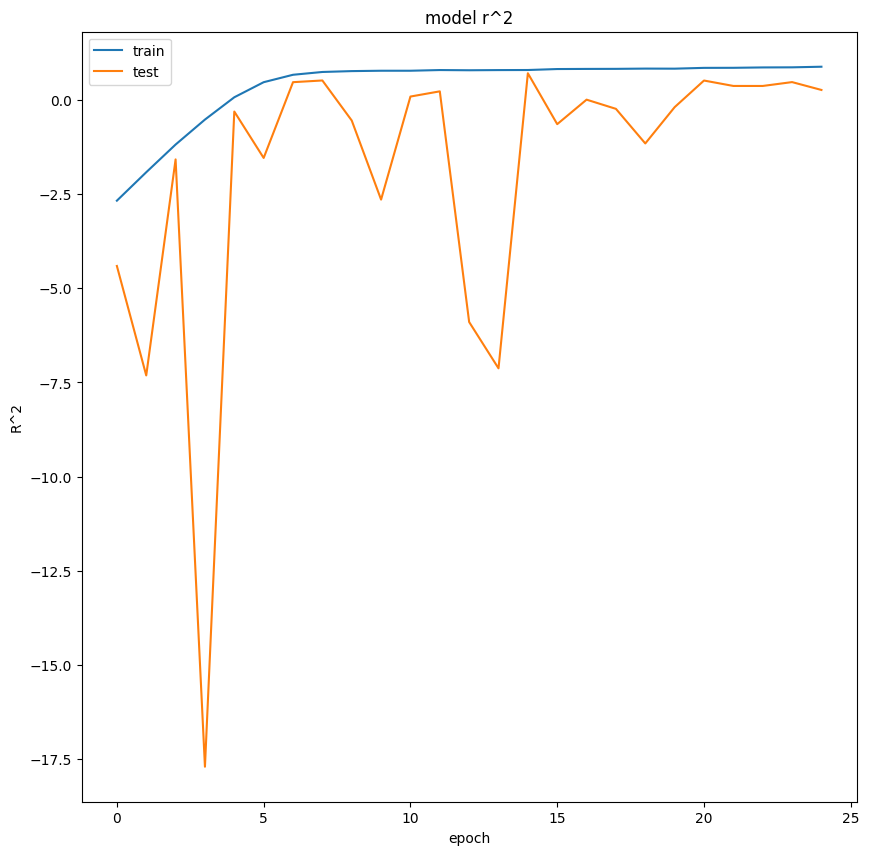

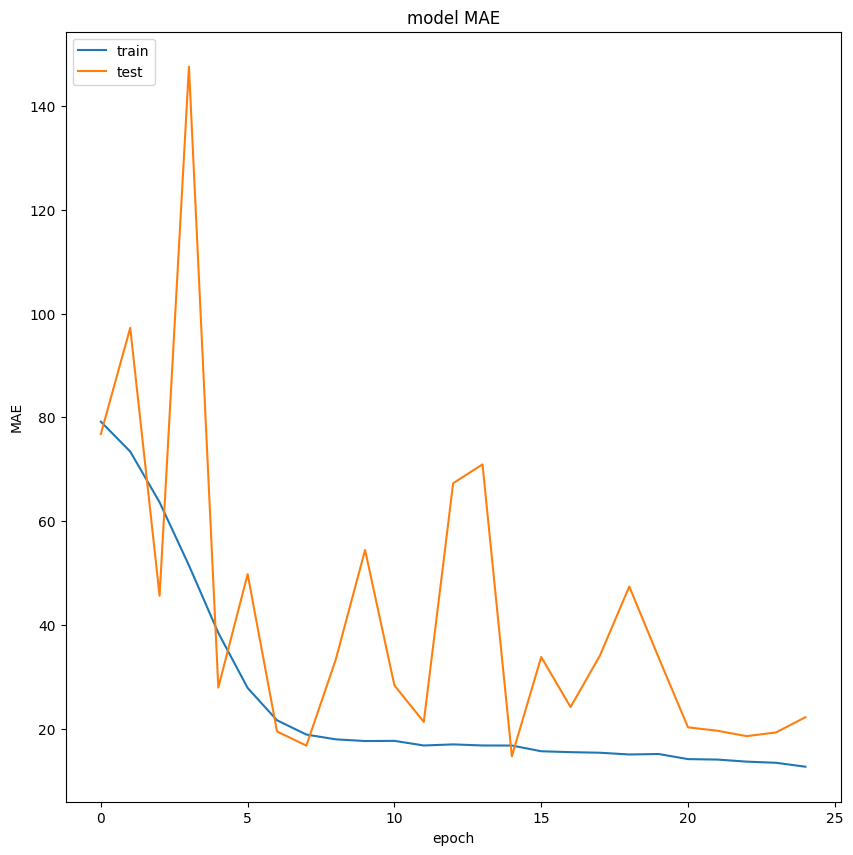

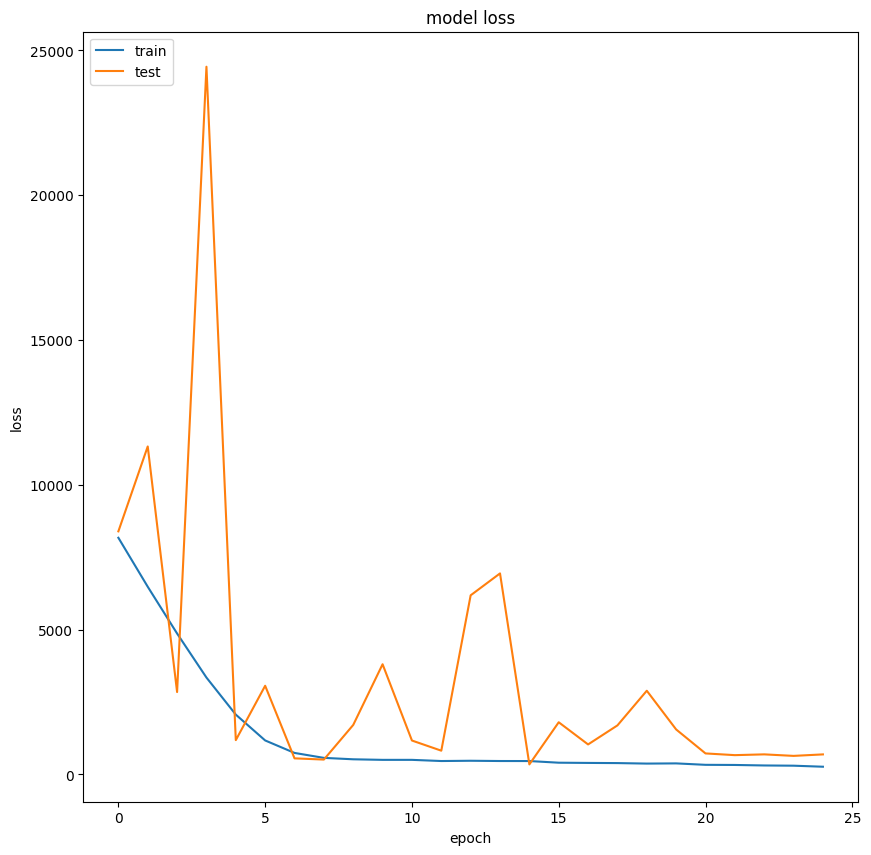

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 38.3309 - mae: 4.9823 - r2_keras: -52127817728.0000 

MAE: 4.981691360473633

R^2: -39867682816.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step

Scoring Function: 72.83004679189017

Average Scoring Function: 0.3501444557302412
test set RMSE: 6.19, R2: 0.00, Scoring Function: 72.83, Average Scoring Function: 0.35


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(6.191471, 0.0, 72.83004670471082, 0.3501444553111097)

In [95]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [96]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 627.3525 - mae: 18.0070 - r2_keras: 0.7671 

MAE: 18.298913955688477

R^2: 0.7551835775375366
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 157.69071278428282
test set RMSE: 25.45, R2: 0.78, Scoring Function: 157.69, Average Scoring Function: 0.61


/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)
/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(25.44766, 0.7760899366361064, 157.69071294206114, 0.6088444515137496)

In [97]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['Adam-Optimizer'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387
3,increase-LSTM-units-do-without-regularizer,80.327904,0.0,207.932475,53.785652,-0.000255,219.504707
4,Add-1-more-LSTM-Layer,79.987534,0.0,207.930137,53.792133,-0.000496,219.521561
5,Adam-Optimizer,6.191471,0.0,72.830047,25.447660,0.776090,157.690713


## 7. Use Adam optimizer + increase dropout rate to 0.5

In [98]:
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras.backend as K

def r2_keras(y_true, y_pred):
    """Coefficient of Determination"""
    SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - SS_res / (SS_tot + K.epsilon())


def lstm_train(seq_array, label_array, sequence_length):
    nb_features = seq_array.shape[2]
    nb_out = label_array.shape[1]

    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True,
        ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(LSTM(
        units=50,
        return_sequences=False,
        ))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))

    # Compile the model with the Adam optimizer
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001), metrics=['mae', r2_keras])

    print(model.summary())

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

    # Fit the network
    history = model.fit(seq_array, label_array, epochs=60, batch_size=200, validation_split=0.05, verbose=2,
                        callbacks=[early_stopping, reduce_lr])

    # List all data in history
    print(history.history.keys())
    
    return model, history

In [99]:
model, history = lstm_train(seq_array, label_array, sequence_length)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_28 (LSTM)                  │ (None, 50, 100)        │        50,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 50, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 50, 100)        │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_29 (LSTM)                  │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 50)             │           200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,851 (315.82 KB)

 Trainable params: 80,551 (314.65 KB)

 Non-trainable params: 300 (1.17 KB)

None
Epoch 1/60
159/159 - 5s - 32ms/step - loss: 8347.9629 - mae: 79.1837 - r2_keras: -2.7494e+00 - val_loss: 14294.6660 - val_mae: 108.0808 - val_r2_keras: -9.0833e+00 - learning_rate: 0.0010
Epoch 2/60
159/159 - 2s - 10ms/step - loss: 6633.2383 - mae: 73.0125 - r2_keras: -1.9983e+00 - val_loss: 5693.6787 - val_mae: 66.2307 - val_r2_keras: -3.4136e+00 - learning_rate: 0.0010
Epoch 3/60
159/159 - 2s - 10ms/step - loss: 4853.1465 - mae: 62.4158 - r2_keras: -1.1825e+00 - val_loss: 6877.4521 - val_mae: 77.3681 - val_r2_keras: -4.9224e+00 - learning_rate: 0.0010
Epoch 4/60
159/159 - 2s - 10ms/step - loss: 3268.4619 - mae: 49.9528 - r2_keras: -4.7234e-01 - val_loss: 1893.4844 - val_mae: 39.0163 - val_r2_keras: -7.7225e-01 - learning_rate: 0.0010
Epoch 5/60
159/159 - 2s - 10ms/step - loss: 2050.2446 - mae: 37.6887 - r2_keras: 0.0612 - val_loss: 4785.1855 - val_mae: 61.5814 - val_r2_keras: -2.7615e+00 - learning_rate: 0.0010
Epoch 6/60
159/159 - 2s - 10ms/step - loss: 1302.8639 - mae: 29.1269

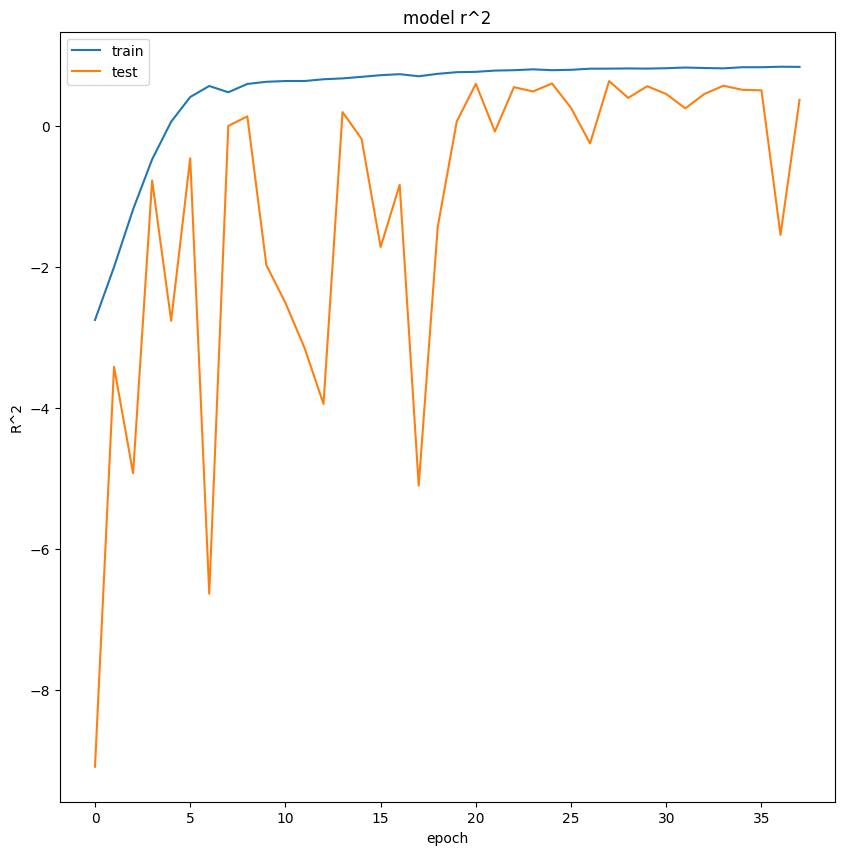

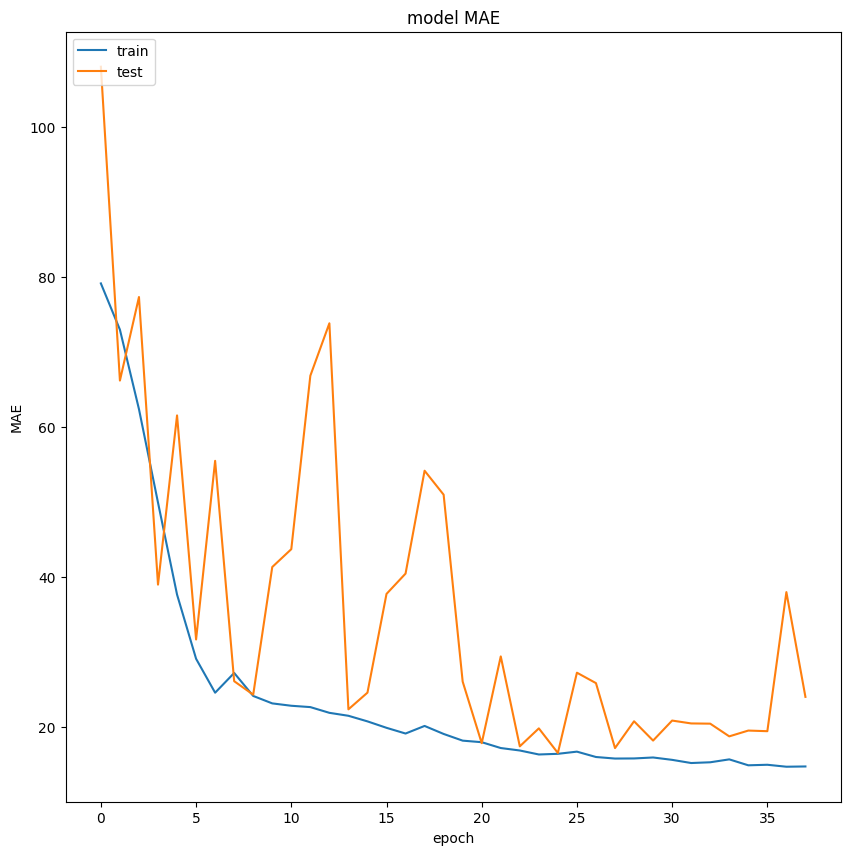

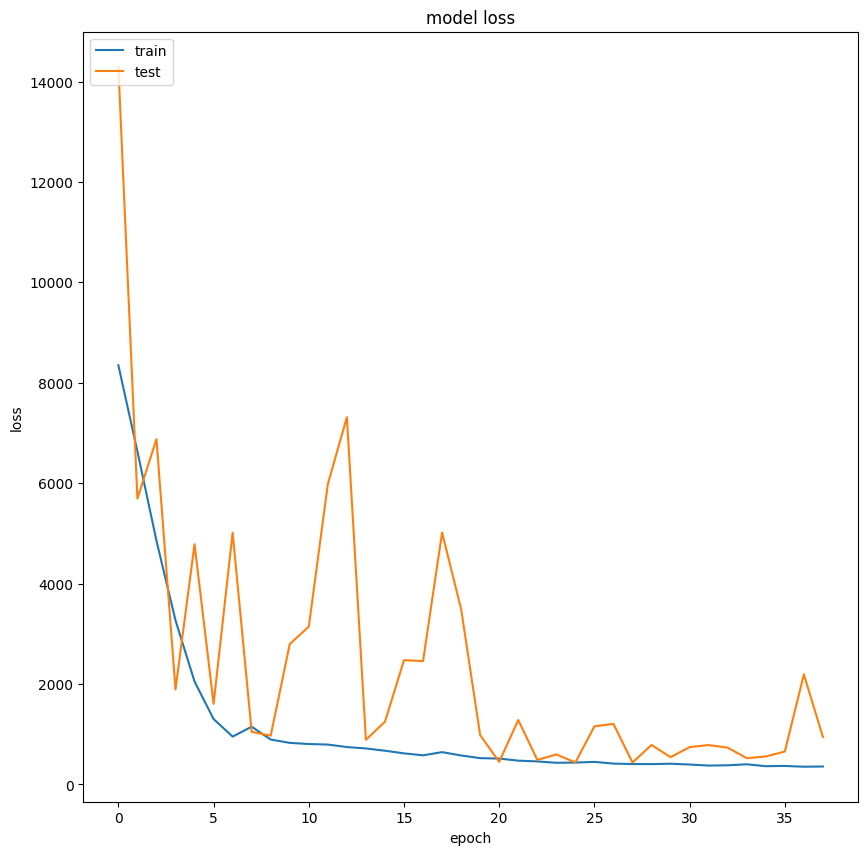

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 263.8999 - mae: 15.9197 - r2_keras: -358717849600.0000 

MAE: 15.927458763122559

R^2: -274758254592.0
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step

Scoring Function: 163.62485145172874

Average Scoring Function: 0.7866579396717728
test set RMSE: 16.25, R2: 0.00, Scoring Function: 163.62, Average Scoring Function: 0.79


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)


(16.253942, 0.0, 163.6248512909174, 0.7866579388986413)

In [100]:
RMSE_Train, R2_Train, Score_Train, average_score_train = lstm_test_evaluation_graphs(model, history, seq_array, label_array, output_train_counter_pad)
RMSE_Train, R2_Train, Score_Train, average_score_train

In [101]:
RMSE_Test, R2_Test, Score_Test, average_score_test = evaluate_test_data(model, test_seq_array, test_label_array, output_test_counter_pad)
RMSE_Test, R2_Test, Score_Test, average_score_test

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 720.8242 - mae: 20.5952 - r2_keras: 0.7416 

MAE: 20.72532844543457

R^2: 0.7367971539497375
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Scoring Function: 181.39045720420302
test set RMSE: 27.05, R2: 0.75, Scoring Function: 181.39, Average Scoring Function: 0.70


/tmp/ipykernel_34/3081272950.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1 -math.exp(-d / 10)
/tmp/ipykernel_34/3081272950.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  score += 1- math.exp(d / 13)


(27.052692, 0.746954354607231, 181.39045706519056, 0.7003492550779559)

In [102]:
Results_pad=pd.concat([Results_pad,pd.DataFrame({'Model':['Adam-Optimizer-+-increase-dropout-rate-to-0.5'],
                                         'RMSE-Train':[RMSE_Train],
                                         'R2-Train':[R2_Train],
                                         'Score-Train':[Score_Train],
                                         'RMSE-Test':[RMSE_Test],
                                         'R2-Test':[R2_Test],
                                         'Score-Test':[Score_Test]})]
                  ,ignore_index=True)
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387
3,increase-LSTM-units-do-without-regularizer,80.327904,0.0,207.932475,53.785652,-0.000255,219.504707
4,Add-1-more-LSTM-Layer,79.987534,0.0,207.930137,53.792133,-0.000496,219.521561
5,Adam-Optimizer,6.191471,0.0,72.830047,25.447660,0.776090,157.690713
6,Adam-Optimizer-+-increase-dropout-rate-to-0.5,16.253942,0.0,163.624851,27.052692,0.746954,181.390457


# Comparison between window sizes of 20 and 50

In [103]:
# window size = 20
Results

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,89.851166,0.0,207.973946,54.472519,-0.025966,220.824491
1,increase-dropout-from-0.2-to-0.5,88.827126,0.0,207.971136,54.319019,-0.020192,220.501713
2,add-kernel-regularizer,89.958946,0.0,207.974225,54.489773,-0.026616,220.843339
3,increase-LSTM-units-do-without-regularizer,89.620949,0.0,207.973339,54.436371,-0.024604,220.772615
4,Add-1-more-LSTM-Layer,89.828171,0.0,207.973886,54.468868,-0.025828,220.820020
5,Adam-Optimizer,15.492359,0.0,158.127418,32.286179,0.639578,175.617768
6,Adam-Optimizer-+-increase-dropout-rate-to-0.5,12.693487,0.0,116.435216,31.034744,0.666977,172.236160


In [104]:
# window size = 50
Results_pad

,Model,RMSE-Train,R2-Train,Score-Train,RMSE-Test,R2-Test,Score-Test
0,LSTM-Baseline,33.242271,0.0,170.222168,47.016628,0.235670,218.166904
1,increase-dropout-from-0.2-to-0.5,78.565018,0.0,207.919457,53.842602,-0.002374,220.010475
2,add-kernel-regularizer,79.927345,0.0,207.929715,53.793507,-0.000547,219.541387
3,increase-LSTM-units-do-without-regularizer,80.327904,0.0,207.932475,53.785652,-0.000255,219.504707
4,Add-1-more-LSTM-Layer,79.987534,0.0,207.930137,53.792133,-0.000496,219.521561
5,Adam-Optimizer,6.191471,0.0,72.830047,25.447660,0.776090,157.690713
6,Adam-Optimizer-+-increase-dropout-rate-to-0.5,16.253942,0.0,163.624851,27.052692,0.746954,181.390457


The results presented for the Remaining Useful Life (RUL) prediction of aircraft engines using LSTM models with different configurations and sliding window sizes (20 and 50) provide several insights into the performance and impact of various hyperparameters and techniques on model accuracy. 

When we compare the results of the models' evaluation metrics of the test set, it can be concluded that models trained using a window size of 50 performed slightly better.

Based on the tables shown above, it can be observed that increasing the dropout rate from 0.2 to 0.5, the addition of a kernel regularizer, increasing the number of LSTM units, or adding one more hidden layer, has a marginal effect on the evaluation metrics for both window sizes of 20 and 50. This is represented by the almost-consistent RMSE, R2 and scoring values.

In contrast, it is notable that switching to the Adam optimizer significantly improved the performance, as observed from the lower RMSE and scoring values, as well as the more positive R2 values on the train and test sets, for both sliding windows of 20 and 50. This suggests that the optimizer plays a crucial role in training efficiency and model performance. For a window size of 50, the model performance does not improve further when the use of Adam optimizer is combined with increasing the dropout rate to 0.5 which is unlike for a window size of 20. The best model performance returns RMSE, R2 and Score values of 25.44, 0.77 and 157.69, respectively.

The significant improvement in the models' performance when using the Adam optimizer compared to the RMSProp optimizer can be attributed to several key differences in how these optimizers work and their suitability for training deep learning models, particularly LSTMs. On the one hand, RMSProp optimizer adjusts the learning rate for each parameter based on the moving average of the squared gradients. It is particularly effective for handling the exploding and vanishing gradient problems in deep learning.On the other hand, Adam combines the advantages of RMSProp and momentum. It maintains an adaptive learning rate for each parameter like in RMSProp, but it additionally keeps an exponentially decaying average of past gradients (momentum). This allows Adam to adapt the learning rate based on both the first moment (mean) and the second moment (uncentered variance) of the gradients. 

The better performance of Adam is attributed to the fact that it is particularly well-suited for problems with sparse gradients, which is common in tasks involving sequences like this time series data in RUL prediction. The experimental results reflect the theoretical advantages of Adam; when the Adam optimizer is used, a significant reduction in RMSE and scoring, as well as a more positive R2 value, is observed, which indicates a better fit. These improvements demonstrate that Adam's adaptive learning rates and momentum help the model learn more efficiently, reducing errors and capturing the underlying patterns in the data better than RMSProp. Given its better model performance, the Adam optimizer should be the default choice of optimizer for training the LSTM models for RUL prediction.
